# Atlas State EV Registration Data
This script consolidates multiple EV registration .CSV files from the Atlas State EV website.   A final dataset with all states is created and saved to disk.   The source data is inconsistent and has data quality issues.  This script corrects issues when possible and cleans or creates new columns. 

**Final Columns:**  'Make', 'Model', 'Model Year', 'Registration Expiration Date', 'Registration Valid Date', 'Registration Valid Month', 'State', 'Technology', 'ZIP Code'

https://github.com/emskiphoto/Alpaca-Strategy-Development
Copyright 2021 Matt Chmielewski
November 5, 2021

#### Reference:
https://www.atlasevhub.com/materials/state-ev-registration-data/#data

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import histogram, logical_and, NAN
from numpy.random import choice

%config Completer.use_jedi = False 
pd.options.display.max_rows = 200

### Which URLS and .csv files are available?

In [2]:
# static list created for all states available on Atlas as of 10/25/2021
urls_raw = ['https://www.atlasevhub.com/public/dmv/ca_ev_registrations_public.csv',
           'https://www.atlasevhub.com/public/dmv/co_ev_registrations_public.csv',
           'https://www.atlasevhub.com/public/dmv/ct_ev_registrations_public.csv',
           'https://www.atlasevhub.com/public/dmv/fl_ev_registrations_public.csv',
           'https://www.atlasevhub.com/public/dmv/mt_ev_registrations_public.csv',
           'https://www.atlasevhub.com/public/dmv/mi_ev_registrations_public.csv',
           'https://www.atlasevhub.com/public/dmv/mn_ev_registrations_public.csv',
           'https://www.atlasevhub.com/public/dmv/nj_ev_registrations_public.csv',
           'https://www.atlasevhub.com/public/dmv/ny_ev_registrations_public.csv',
          'https://www.atlasevhub.com/public/dmv/or_ev_registrations_public.csv',
           'https://www.atlasevhub.com/public/dmv/tn_ev_registrations_public.csv',
           'https://www.atlasevhub.com/public/dmv/tx_ev_registrations_public.csv',
           'https://www.atlasevhub.com/public/dmv/vt_ev_registrations_public.csv',
           'https://www.atlasevhub.com/public/dmv/va_ev_registrations_public.csv',
           'https://www.atlasevhub.com/public/dmv/wa_ev_registrations_public.csv',
           'https://www.atlasevhub.com/public/dmv/wi_ev_registrations_public.csv']

In [3]:
urls = {url.split('dmv/')[-1].split('_ev')[0].upper():url for url in urls_raw}

In [4]:
urls

{'CA': 'https://www.atlasevhub.com/public/dmv/ca_ev_registrations_public.csv',
 'CO': 'https://www.atlasevhub.com/public/dmv/co_ev_registrations_public.csv',
 'CT': 'https://www.atlasevhub.com/public/dmv/ct_ev_registrations_public.csv',
 'FL': 'https://www.atlasevhub.com/public/dmv/fl_ev_registrations_public.csv',
 'MT': 'https://www.atlasevhub.com/public/dmv/mt_ev_registrations_public.csv',
 'MI': 'https://www.atlasevhub.com/public/dmv/mi_ev_registrations_public.csv',
 'MN': 'https://www.atlasevhub.com/public/dmv/mn_ev_registrations_public.csv',
 'NJ': 'https://www.atlasevhub.com/public/dmv/nj_ev_registrations_public.csv',
 'NY': 'https://www.atlasevhub.com/public/dmv/ny_ev_registrations_public.csv',
 'OR': 'https://www.atlasevhub.com/public/dmv/or_ev_registrations_public.csv',
 'TN': 'https://www.atlasevhub.com/public/dmv/tn_ev_registrations_public.csv',
 'TX': 'https://www.atlasevhub.com/public/dmv/tx_ev_registrations_public.csv',
 'VT': 'https://www.atlasevhub.com/public/dmv/vt_ev_

### Preview a table from one state

In [5]:
df = pd.read_csv(urls[list(urls.keys())[-1]], nrows=100)
df

,DMV ID,DMV Snapshot (Date),ZIP Code,VIN Prefix,VIN Model Year,Registration Valid Date,Registration Expiration Date,Make,Model,Model Year
0,1,DMV Direct (6/30/2018),30348,1FADP5FU,H,6/30/2018,NaN,Ford,C-Max Energi,2017
1,1,DMV Direct (6/30/2018),48126,1FADP5FU,H,6/30/2018,NaN,Ford,C-Max Energi,2017
2,1,DMV Direct (6/30/2018),52101,1FADP5FU,H,6/30/2018,NaN,Ford,C-Max Energi,2017
3,1,DMV Direct (6/30/2018),53005,1FADP5FU,H,6/30/2018,NaN,Ford,C-Max Energi,2017
4,1,DMV Direct (6/30/2018),53045,1FADP5FU,H,6/30/2018,NaN,Ford,C-Max Energi,2017
5,1,DMV Direct (6/30/2018),53073,1FADP5FU,H,6/30/2018,NaN,Ford,C-Max Energi,2017
6,1,DMV Direct (6/30/2018),53092,1FADP5FU,H,6/30/2018,NaN,Ford,C-Max Energi,2017
7,1,DMV Direct (6/30/2018),53126,1FADP5FU,H,6/30/2018,NaN,Ford,C-Max Energi,2017
8,1,DMV Direct (6/30/2018),53168,1FADP5FU,H,6/30/2018,NaN,Ford,C-Max Energi,2017
9,1,DMV Direct (6/30/2018),53209,1FADP5FU,H,6/30/2018,NaN,Ford,C-Max Energi,2017


### Read all csv files from list of URLs and store in dictionary

In [6]:
%%time
csvs_by_state = {}
global total_records
global n_states
total_records = 0
n_states = len(urls.keys())
count = 1
for state in urls:
    t0 = time.time()
    print(state.upper())
    temp = pd.read_csv(urls[state], parse_dates=['Registration Expiration Date', 'Registration Valid Date'])
    csvs_by_state[state.upper()] = temp
    t1 = time.time()
    total = t1-t0
    total_records += temp.shape[0] 
    print(f'{count} of {n_states}:  "{state}" has {temp.shape[0]:,} rows and required {round(total,1)} seconds to load')
    count+=1
print(f'\n***  There are {total_records:,} records for {n_states} states ***')

CA


<decorator-gen-62>:2: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.


1 of 16:  "CA" has 2,542,443 rows and required 36.7 seconds to load
CO
2 of 16:  "CO" has 788,003 rows and required 10.7 seconds to load
CT
3 of 16:  "CT" has 11,439 rows and required 1.3 seconds to load
FL
4 of 16:  "FL" has 353,974 rows and required 13.7 seconds to load
MT
5 of 16:  "MT" has 2,847 rows and required 0.7 seconds to load
MI
6 of 16:  "MI" has 43,628 rows and required 2.8 seconds to load
MN
7 of 16:  "MN" has 49,473 rows and required 1.3 seconds to load
NJ
8 of 16:  "NJ" has 198,901 rows and required 2.5 seconds to load
NY
9 of 16:  "NY" has 2,371,089 rows and required 38.7 seconds to load
OR
10 of 16:  "OR" has 65,683 rows and required 1.5 seconds to load
TN
11 of 16:  "TN" has 111,478 rows and required 2.1 seconds to load
TX
12 of 16:  "TX" has 575,542 rows and required 7.9 seconds to load
VT
13 of 16:  "VT" has 26,515 rows and required 2.1 seconds to load
VA
14 of 16:  "VA" has 82,739 rows and required 2.1 seconds to load
WA
15 of 16:  "WA" has 1,941,247 rows and requ

## The Columns used across all 16 state's csv's are not consistent

In [7]:
csvs_by_state['MN'].head(2)

,DMV ID,DMV Snapshot (Date),ZIP Code,Registration Expiration Date,VIN Prefix,VIN Model Year,Registration Valid Date,Make,Model,Model Year
0,7,DMV Direct (6/1/2021),56537.0,6/30/2022,1G1FZ6S0,K,2021-06-12,Chevrolet,Bolt EV,2019
1,7,DMV Direct (6/1/2021),55103.0,6/30/2022,1G1FZ6S0,K,2021-06-08,Chevrolet,Bolt EV,2019


In [8]:
csvs_by_state['CO'].head(2)

,ZIP Code,Registration Valid Date,VIN Prefix,DMV ID,DMV Snapshot,VIN Model Year,Registration Expiration Date,State,Vehicle Name,Technology
0,80134,2019-10-30,5YJ3E1EB,18,CO DMV Direct (8/1/2020),K,2020-10-31,CO,Tesla Model 3,BEV
1,80503,2020-07-08,1N4AZ1CP,18,CO DMV Direct (8/1/2020),J,2021-07-31,CO,Nissan Leaf,BEV


### Identify Columns common to all csv's

In [9]:
all_csvs_columns = []
for state in csvs_by_state:
    all_csvs_columns.append(list(csvs_by_state[state].columns))
    
common_cols = list(set.intersection(*[set(list) for list in all_csvs_columns]))

In [10]:
common_cols

['Registration Expiration Date', 'Registration Valid Date', 'DMV ID']

In [11]:
csv_columns_dict = dict(zip(csvs_by_state.keys(), all_csvs_columns))

In [12]:
for state in csvs_by_state:
    print(state)
    display(csvs_by_state[state].head(2))

CA


,Vehicle ID,County GEOID,Registration Valid Date,DMV ID,DMV Snapshot,Registration Expiration Date,State Abbreviation,Geography,Vehicle Name
0,CA-002-03597\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaT,CA,County,Chevrolet Volt
1,CA-002-03598\r,06105,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaT,CA,County,Nissan Leaf


CO


,ZIP Code,Registration Valid Date,VIN Prefix,DMV ID,DMV Snapshot,VIN Model Year,Registration Expiration Date,State,Vehicle Name,Technology
0,80134,2019-10-30,5YJ3E1EB,18,CO DMV Direct (8/1/2020),K,2020-10-31,CO,Tesla Model 3,BEV
1,80503,2020-07-08,1N4AZ1CP,18,CO DMV Direct (8/1/2020),J,2021-07-31,CO,Nissan Leaf,BEV


CT


,DMV ID,DMV Snapshot (Date),ZIP Code,Registration Valid Date,Registration Expiration Date,VIN Prefix,VIN Model Year,Make,Model,Model Year
0,2,DMV Direct (1/4/2018),6457,2018-01-04,12/31/2018,1G1FX6S0,H,Chevrolet,Bolt EV,2017
1,2,DMV Direct (1/4/2018),6278,2018-01-04,12/31/2018,1G1FX6S0,H,Chevrolet,Bolt EV,2017


FL


,DMV ID,DMV Snapshot (Date),County,Vehicle Name,Registration Valid Date,Registration Expiration Date,Technology
0,1,Registration Data from FPL (6/30/2018),Dade,Tesla Model X,2018-06-30,NaT,BEV
1,1,Registration Data from FPL (6/30/2018),Dade,Tesla Model X,2018-06-30,NaT,BEV


MT


,DMV ID,DMV Snapshot (Date),Registration Valid Date,County GEOID,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year
0,2,DMV Direct (1/21/2021),2019-12-01,30031,5YJ3E1EB,11/30/2020,J,Tesla,Model 3,2018
1,2,DMV Direct (1/21/2021),2019-12-01,30013,1G1RD6E4,11/30/2020,E,Chevrolet,Volt,2014


MI


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year
0,1,DMV Direct (3/3/2018),2017-11-14,48380,1FADP5CU,NaT,D,Ford,C-Max Energi,2013
1,1,DMV Direct (3/3/2018),2017-11-14,48173,5YJSA1E4,NaT,H,Tesla,Model S,2017


MN


,DMV ID,DMV Snapshot (Date),ZIP Code,Registration Expiration Date,VIN Prefix,VIN Model Year,Registration Valid Date,Make,Model,Model Year
0,7,DMV Direct (6/1/2021),56537.0,6/30/2022,1G1FZ6S0,K,2021-06-12,Chevrolet,Bolt EV,2019
1,7,DMV Direct (6/1/2021),55103.0,6/30/2022,1G1FZ6S0,K,2021-06-08,Chevrolet,Bolt EV,2019


NJ


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,VIN Model Year,Registration Expiration Date,Make,Model,Model Year
0,16,MVC Direct (12/31/2020),2020-12-31,8083,5YJ3E1EB,J,NaT,Tesla,Model 3,2018
1,16,MVC Direct (12/31/2020),2020-12-31,7430,5YJ3E1EB,J,NaT,Tesla,Model 3,2018


NY


,ZIP Code,Registration Valid Date,VIN Prefix,DMV ID,DMV Snapshot,VIN Model Year,Registration Expiration Date,State,Vehicle Name,Technology
0,11230,2018-04-09,1N4AZ0CP,29,NY DATA.NY.GOV (6/02/2019),D,2020-01-31,NY,Nissan Leaf,BEV
1,13219,2018-01-24,1N4AZ0CP,29,NY DATA.NY.GOV (6/02/2019),D,2020-02-11,NY,Nissan Leaf,BEV


OR


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year
0,2,DMV Direct (12/31/2020),2020-12-31,97209.0,5YJYGDEE,2024-11-14,M,Tesla,Model Y,2021
1,2,DMV Direct (12/31/2020),2020-12-28,97034.0,5YJYGDEE,2024-11-03,M,Tesla,Model Y,2021


TN


,DMV ID,DMV Snapshot (Date),Registration Valid Date,County GEOID,County Name,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Technology
0,11,DMV Direct (9/30/2021),2021-09-30,47093,Knox County,1G1RA6E4,2023-09-30,C,Chevrolet,Volt,2012,PHEV
1,11,DMV Direct (9/30/2021),2021-09-30,47093,Knox County,1G1RA6E4,2023-09-30,C,Chevrolet,Volt,2012,PHEV


TX


,DMV ID,DMV Snapshot (Date),ZIP Code,Vehicle Name,Registration Valid Date,Registration Expiration Date
0,1,Registration Data from DFW Clean Cities (6/3/2...,3106.0,Tesla Model S,2019-06-03,NaT
1,1,Registration Data from DFW Clean Cities (6/3/2...,3106.0,Tesla Model S,2019-06-03,NaT


VT


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year
0,2,DMV Direct (3/30/2019),2019-12-28,5055,JTDKARFP,2019-04-01,J,Toyota,Prius Prime,2018
1,2,DMV Direct (3/30/2019),2019-03-19,5154,JTDKARFP,2021-03-01,J,Toyota,Prius Prime,2018


VA


,DMV ID,DMV Snapshot (Date),Registration Valid Date,Registration Expiration Date,County GEOID,VIN Prefix,VIN Model Year,Make,Model,Model Year
0,4,DMV Direct (1/01/2021),2021-01-01,2022-01-31,51059,1G1RD6S5,K,Chevrolet,Volt,2019
1,4,DMV Direct (1/01/2021),2020-12-10,2022-12-31,51107,1G1RD6S5,K,Chevrolet,Volt,2019


WA


,Vehicle ID,ZIP Code,Registration Valid Date,VIN Prefix,VIN Model Year,DMV ID,DMV ID Complete,DMV Snapshot,Registration Expiration Date,State Abbreviation,Geography,Vehicle Name,Technology
0,WA-042-114407051,98075,2021-10-14,5YJSA1S2,F,42,WA42,WA DMV Direct (10/14/2021),NaN,WA,ZIP Code,Tesla Model S,BEV
1,WA-042-209671381,98125,2021-10-14,JTDKN3DP,E,42,WA42,WA DMV Direct (10/14/2021),NaN,WA,ZIP Code,Toyota Prius Plug-in,PHEV


WI


,DMV ID,DMV Snapshot (Date),ZIP Code,VIN Prefix,VIN Model Year,Registration Valid Date,Registration Expiration Date,Make,Model,Model Year
0,1,DMV Direct (6/30/2018),30348,1FADP5FU,H,2018-06-30,NaT,Ford,C-Max Energi,2017
1,1,DMV Direct (6/30/2018),48126,1FADP5FU,H,2018-06-30,NaT,Ford,C-Max Energi,2017


In [13]:
all_csvs_columns

[['Vehicle ID',
  'County GEOID',
  'Registration Valid Date',
  'DMV ID',
  'DMV Snapshot',
  'Registration Expiration Date',
  'State Abbreviation',
  'Geography',
  'Vehicle Name'],
 ['ZIP Code',
  'Registration Valid Date',
  'VIN Prefix',
  'DMV ID',
  'DMV Snapshot',
  'VIN Model Year',
  'Registration Expiration Date',
  'State',
  'Vehicle Name',
  'Technology'],
 ['DMV ID',
  'DMV Snapshot (Date)',
  'ZIP Code',
  'Registration Valid Date',
  'Registration Expiration Date',
  'VIN Prefix',
  'VIN Model Year',
  'Make',
  'Model',
  'Model Year'],
 ['DMV ID',
  'DMV Snapshot (Date)',
  'County',
  'Vehicle Name',
  'Registration Valid Date',
  'Registration Expiration Date',
  'Technology'],
 ['DMV ID',
  'DMV Snapshot (Date)',
  'Registration Valid Date',
  'County GEOID',
  'VIN Prefix',
  'Registration Expiration Date',
  'VIN Model Year',
  'Make',
  'Model',
  'Model Year'],
 ['DMV ID',
  'DMV Snapshot (Date)',
  'Registration Valid Date',
  'ZIP Code',
  'VIN Prefix',
  '

#### Only a few columns are found in all of the states csv files - which column names are more frequent?

In [14]:
all_columns = [i[x] for i in all_csvs_columns for x in range(len(i))]
pd.Series(all_columns).value_counts()

Registration Expiration Date    16
Registration Valid Date         16
DMV ID                          16
VIN Model Year                  13
VIN Prefix                      13
DMV Snapshot (Date)             12
ZIP Code                        11
Model Year                      10
Model                           10
Make                            10
Vehicle Name                     6
Technology                       5
DMV Snapshot                     4
County GEOID                     4
State                            2
Vehicle ID                       2
State Abbreviation               2
Geography                        2
County                           1
County Name                      1
DMV ID Complete                  1
dtype: int64

## Format desired columns to create a single comprehensive dataset

In [15]:
# csvs_by_state_backup = csvs_by_state.copy()
# csvs_by_state = csvs_by_state_backup.copy()

### Registration Valid Date
Are all states reporting this value and is date format converted to datetime?

#### Count number of invalid (NaN) dates are present in Registration Valid Date for each state

In [16]:
nan_registration_valid_dates = {}
nan_reg_valid_and_expiration_dates = {}
nan_model_year_and_expiration_dates = {}
for state in csvs_by_state:
    nan_valid_dates = pd.to_datetime(csvs_by_state[state]['Registration Valid Date'], errors='ignore').isna()
    nan_expiration_dates = pd.to_datetime(csvs_by_state[state]['Registration Expiration Date'], errors='ignore').isna()
#     nan_model_years = csvs_by_state[state]['Model Year'].isna().sum()
    nan_registration_valid_dates[state] = pd.to_datetime(csvs_by_state[state]['Registration Valid Date'], errors='ignore').isna().sum()
    nan_registration_valid_and_expiration_dates =  logical_and(nan_valid_dates, nan_expiration_dates)
#     nan_model_year_and_expiration_dates_ =  np.logical_and(nan_expiration_dates, nan_model_years)
    nan_reg_valid_and_expiration_dates[state] = nan_registration_valid_and_expiration_dates.sum()
#     nan_model_year_and_expiration_dates[state] = nan_registration_valid_and_expiration_dates_.sum()
#     display(pd.to_datetime(csvs_by_state[state]['Registration Valid Date']).isna().sum())

In [17]:
nan_registration_valid_dates

{'CA': 0,
 'CO': 0,
 'CT': 0,
 'FL': 0,
 'MT': 0,
 'MI': 0,
 'MN': 101,
 'NJ': 0,
 'NY': 0,
 'OR': 25436,
 'TN': 0,
 'TX': 0,
 'VT': 20319,
 'VA': 0,
 'WA': 0,
 'WI': 0}

In [18]:
nan_reg_valid_and_expiration_dates

{'CA': 0,
 'CO': 0,
 'CT': 0,
 'FL': 0,
 'MT': 0,
 'MI': 0,
 'MN': 98,
 'NJ': 0,
 'NY': 0,
 'OR': 700,
 'TN': 0,
 'TX': 0,
 'VT': 0,
 'VA': 0,
 'WA': 0,
 'WI': 0}

#### Correct 'Registration Valid Date'
**Logic:** If The 'Registration Expiration Date' is available, set the 'Registration Valid Date' equal to the 'Registration Expiration Date' minus one year.  If 'Registration Expiration Date' is not available (either) _and_ 'Model Year' is available, assume 'Registration Valid Date' is equal to January 01 of the 'Model Year'.  If 'Registration Expiration Date', 'Model Year' and 'Registration Valid Date' are not available, randomly assign dates based on the weighted distribution (histogram) from the valid dates in that state's dataset.  If none of these options is available, leave the dates as 'NaN/NaT'

#### Fill missing date using model year and random month based on known distribution of valid registration months

In [19]:
# (pd.to_datetime(csvs_by_state['MN']['Registration Expiration Date'], errors='ignore') - pd.Timedelta(days=365))

In [20]:
# (pd.to_datetime(csvs_by_state['MN']['Registration Expiration Date'], errors='ignore') - pd.Timedelta(days=365)).isna().sum()

In [21]:
nan_reg_date_states = [state for state in nan_registration_valid_dates if nan_registration_valid_dates[state] > 0]
for state in nan_reg_date_states:
    print(state)
    columns = list(csvs_by_state[state].columns)
#     nan_reg_date_records = csvs_by_state[state]['Registration Valid Date'].isna()
    month_weights = histogram(csvs_by_state[state]['Registration Valid Date'].dt.month.dropna(), range=(1,13),bins=12, density=True)[0]
    if 'Registration Valid Date' in columns and 'Model Year' in columns:
        csvs_by_state[state]['Registration Valid Date'] = pd.to_datetime(csvs_by_state[state]\
                         ['Registration Valid Date'], errors='ignore')\
                        .fillna(csvs_by_state[state]['Model Year']\
                        .apply(lambda model_year: pd.Timestamp(model_year,
                       int(choice(range(1,13), size=1, p=month_weights)),1)))
    else:
        print(f'{state}:  Registration Valid Date and Model Year not in columns')


MN
OR
VT


#### Check for remaining NaN values in 'Registration Valid Date'

In [22]:
# nan_registration_valid_dates = {}
for state in csvs_by_state:
    print(state, pd.to_datetime(csvs_by_state[state]['Registration Valid Date']).isna().sum())
#     display(pd.to_datetime(csvs_by_state[state]['Registration Valid Date']).isna().sum())

CA 0
CO 0
CT 0
FL 0
MT 0
MI 0
MN 0
NJ 0
NY 0
OR 0
TN 0
TX 0
VT 0
VA 0
WA 0
WI 0


In [23]:
nan_registration_valid_dates

{'CA': 0,
 'CO': 0,
 'CT': 0,
 'FL': 0,
 'MT': 0,
 'MI': 0,
 'MN': 101,
 'NJ': 0,
 'NY': 0,
 'OR': 25436,
 'TN': 0,
 'TX': 0,
 'VT': 20319,
 'VA': 0,
 'WA': 0,
 'WI': 0}

In [24]:
csvs_by_state[nan_reg_date_states[0]].loc[csvs_by_state[nan_reg_date_states[0]]['Registration Valid Date'].isna()]

,DMV ID,DMV Snapshot (Date),ZIP Code,Registration Expiration Date,VIN Prefix,VIN Model Year,Registration Valid Date,Make,Model,Model Year


In [25]:
for state in nan_registration_valid_dates:
    if nan_registration_valid_dates[state] > 0:
#         display(csvs_by_state[state].loc[csvs_by_state[state]['Registration Valid Date'].isna(),'Registration Valid Date'][:10])
#         if 'Registration Expiration Date'
        display(csvs_by_state[state].loc[csvs_by_state[state]['Registration Valid Date'].isna(),['Registration Valid Date','Registration Expiration Date']][:10])

,Registration Valid Date,Registration Expiration Date


,Registration Valid Date,Registration Expiration Date


,Registration Valid Date,Registration Expiration Date


### Registration Valid Month
It's assumed that the month of registration is valuable to identify shorter-term trends

In [26]:
for state in csvs_by_state:
#     print(state)
    csvs_by_state[state]['Registration Valid Month'] = csvs_by_state[state]['Registration Valid Date'].dt.month.astype('int')

In [27]:
for state in csvs_by_state:
    print(state)
    display(csvs_by_state[state].head(2))

CA


,Vehicle ID,County GEOID,Registration Valid Date,DMV ID,DMV Snapshot,Registration Expiration Date,State Abbreviation,Geography,Vehicle Name,Registration Valid Month
0,CA-002-03597\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaT,CA,County,Chevrolet Volt,1
1,CA-002-03598\r,06105,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaT,CA,County,Nissan Leaf,1


CO


,ZIP Code,Registration Valid Date,VIN Prefix,DMV ID,DMV Snapshot,VIN Model Year,Registration Expiration Date,State,Vehicle Name,Technology,Registration Valid Month
0,80134,2019-10-30,5YJ3E1EB,18,CO DMV Direct (8/1/2020),K,2020-10-31,CO,Tesla Model 3,BEV,10
1,80503,2020-07-08,1N4AZ1CP,18,CO DMV Direct (8/1/2020),J,2021-07-31,CO,Nissan Leaf,BEV,7


CT


,DMV ID,DMV Snapshot (Date),ZIP Code,Registration Valid Date,Registration Expiration Date,VIN Prefix,VIN Model Year,Make,Model,Model Year,Registration Valid Month
0,2,DMV Direct (1/4/2018),6457,2018-01-04,12/31/2018,1G1FX6S0,H,Chevrolet,Bolt EV,2017,1
1,2,DMV Direct (1/4/2018),6278,2018-01-04,12/31/2018,1G1FX6S0,H,Chevrolet,Bolt EV,2017,1


FL


,DMV ID,DMV Snapshot (Date),County,Vehicle Name,Registration Valid Date,Registration Expiration Date,Technology,Registration Valid Month
0,1,Registration Data from FPL (6/30/2018),Dade,Tesla Model X,2018-06-30,NaT,BEV,6
1,1,Registration Data from FPL (6/30/2018),Dade,Tesla Model X,2018-06-30,NaT,BEV,6


MT


,DMV ID,DMV Snapshot (Date),Registration Valid Date,County GEOID,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Registration Valid Month
0,2,DMV Direct (1/21/2021),2019-12-01,30031,5YJ3E1EB,11/30/2020,J,Tesla,Model 3,2018,12
1,2,DMV Direct (1/21/2021),2019-12-01,30013,1G1RD6E4,11/30/2020,E,Chevrolet,Volt,2014,12


MI


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Registration Valid Month
0,1,DMV Direct (3/3/2018),2017-11-14,48380,1FADP5CU,NaT,D,Ford,C-Max Energi,2013,11
1,1,DMV Direct (3/3/2018),2017-11-14,48173,5YJSA1E4,NaT,H,Tesla,Model S,2017,11


MN


,DMV ID,DMV Snapshot (Date),ZIP Code,Registration Expiration Date,VIN Prefix,VIN Model Year,Registration Valid Date,Make,Model,Model Year,Registration Valid Month
0,7,DMV Direct (6/1/2021),56537.0,6/30/2022,1G1FZ6S0,K,2021-06-12,Chevrolet,Bolt EV,2019,6
1,7,DMV Direct (6/1/2021),55103.0,6/30/2022,1G1FZ6S0,K,2021-06-08,Chevrolet,Bolt EV,2019,6


NJ


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,VIN Model Year,Registration Expiration Date,Make,Model,Model Year,Registration Valid Month
0,16,MVC Direct (12/31/2020),2020-12-31,8083,5YJ3E1EB,J,NaT,Tesla,Model 3,2018,12
1,16,MVC Direct (12/31/2020),2020-12-31,7430,5YJ3E1EB,J,NaT,Tesla,Model 3,2018,12


NY


,ZIP Code,Registration Valid Date,VIN Prefix,DMV ID,DMV Snapshot,VIN Model Year,Registration Expiration Date,State,Vehicle Name,Technology,Registration Valid Month
0,11230,2018-04-09,1N4AZ0CP,29,NY DATA.NY.GOV (6/02/2019),D,2020-01-31,NY,Nissan Leaf,BEV,4
1,13219,2018-01-24,1N4AZ0CP,29,NY DATA.NY.GOV (6/02/2019),D,2020-02-11,NY,Nissan Leaf,BEV,1


OR


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Registration Valid Month
0,2,DMV Direct (12/31/2020),2020-12-31,97209.0,5YJYGDEE,2024-11-14,M,Tesla,Model Y,2021,12
1,2,DMV Direct (12/31/2020),2020-12-28,97034.0,5YJYGDEE,2024-11-03,M,Tesla,Model Y,2021,12


TN


,DMV ID,DMV Snapshot (Date),Registration Valid Date,County GEOID,County Name,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Technology,Registration Valid Month
0,11,DMV Direct (9/30/2021),2021-09-30,47093,Knox County,1G1RA6E4,2023-09-30,C,Chevrolet,Volt,2012,PHEV,9
1,11,DMV Direct (9/30/2021),2021-09-30,47093,Knox County,1G1RA6E4,2023-09-30,C,Chevrolet,Volt,2012,PHEV,9


TX


,DMV ID,DMV Snapshot (Date),ZIP Code,Vehicle Name,Registration Valid Date,Registration Expiration Date,Registration Valid Month
0,1,Registration Data from DFW Clean Cities (6/3/2...,3106.0,Tesla Model S,2019-06-03,NaT,6
1,1,Registration Data from DFW Clean Cities (6/3/2...,3106.0,Tesla Model S,2019-06-03,NaT,6


VT


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Registration Valid Month
0,2,DMV Direct (3/30/2019),2019-12-28,5055,JTDKARFP,2019-04-01,J,Toyota,Prius Prime,2018,12
1,2,DMV Direct (3/30/2019),2019-03-19,5154,JTDKARFP,2021-03-01,J,Toyota,Prius Prime,2018,3


VA


,DMV ID,DMV Snapshot (Date),Registration Valid Date,Registration Expiration Date,County GEOID,VIN Prefix,VIN Model Year,Make,Model,Model Year,Registration Valid Month
0,4,DMV Direct (1/01/2021),2021-01-01,2022-01-31,51059,1G1RD6S5,K,Chevrolet,Volt,2019,1
1,4,DMV Direct (1/01/2021),2020-12-10,2022-12-31,51107,1G1RD6S5,K,Chevrolet,Volt,2019,12


WA


,Vehicle ID,ZIP Code,Registration Valid Date,VIN Prefix,VIN Model Year,DMV ID,DMV ID Complete,DMV Snapshot,Registration Expiration Date,State Abbreviation,Geography,Vehicle Name,Technology,Registration Valid Month
0,WA-042-114407051,98075,2021-10-14,5YJSA1S2,F,42,WA42,WA DMV Direct (10/14/2021),NaN,WA,ZIP Code,Tesla Model S,BEV,10
1,WA-042-209671381,98125,2021-10-14,JTDKN3DP,E,42,WA42,WA DMV Direct (10/14/2021),NaN,WA,ZIP Code,Toyota Prius Plug-in,PHEV,10


WI


,DMV ID,DMV Snapshot (Date),ZIP Code,VIN Prefix,VIN Model Year,Registration Valid Date,Registration Expiration Date,Make,Model,Model Year,Registration Valid Month
0,1,DMV Direct (6/30/2018),30348,1FADP5FU,H,2018-06-30,NaT,Ford,C-Max Energi,2017,6
1,1,DMV Direct (6/30/2018),48126,1FADP5FU,H,2018-06-30,NaT,Ford,C-Max Energi,2017,6


### State
some states do not include 'State' in their tables.  Obviously the state is known from the title of the source document.  Force a State column if the file does not already include one

In [28]:
state_abbreviations = pd.read_csv('source/USA State Names_Abbreviations.csv', index_col=0)['State Abbreviation'].to_dict()
state_abbreviations = {v:k for k, v in state_abbreviations.items()}
# state_abbreviations

In [29]:
for state in csvs_by_state:
#     print(state)
    csvs_by_state[state]['State'] = state_abbreviations[state]
#     display('state' in csvs_by_state[state].columns.str.lower().to_list())
#     display(any('state' in col for col in csvs_by_state[state].columns.str.lower().to_list()))
#     display('tate' in csvs_by_state[state].columns.any())
#     display(csvs_by_state[state]['Registration Valid Date'].dtype)

In [30]:
csvs_by_state[state][:2]

,DMV ID,DMV Snapshot (Date),ZIP Code,VIN Prefix,VIN Model Year,Registration Valid Date,Registration Expiration Date,Make,Model,Model Year,Registration Valid Month,State
0,1,DMV Direct (6/30/2018),30348,1FADP5FU,H,2018-06-30,NaT,Ford,C-Max Energi,2017,6,Wisconsin
1,1,DMV Direct (6/30/2018),48126,1FADP5FU,H,2018-06-30,NaT,Ford,C-Max Energi,2017,6,Wisconsin


### Vehicle Model Year
Some tables contain this data, but not all.  The Model year can be derived from the VIN number.  "The model year is encoded in position 10 of North American VIN codes." 

https://en.wikipedia.org/wiki/Vehicle_identification_number

In [31]:
vin_file = "source/VIN Model Year.csv"
df_vin_file = pd.read_csv(vin_file, index_col=0)
model_year_by_VIN = dict(df_vin_file['Model Year'])
# model_year_by_VIN
df_vin_file.iloc[13:23]

,Model Year
VIN Model Year,
E,2014
F,2015
G,2016
H,2017
J,2018
K,2019
L,2020
M,2021
N,2022


#### The VIN digit or VIN number is not available for all states
ASSUME that the 'year' of the Registration Valid Date is also the Model Year of the vehicle.  Note that this may not be accurate, particularly when the original owner sells the vehicle and it is re-registered under another name.

**Model Year assignment logic:**
If 'Model Year' is present, retain the value and make no changes.   If not, search for "VIN Model Year" column.  If the "VIN Model Year" contains 4-digit numbers only, copy this column as the 'Model Year'.  If the "VIN Model Year" contains a mix of single-character letters or numbers, convert these characters to 'Model Year' using the model_year_by_VIN dictionary.  If the model_year_by_VIN dictionary returns a 'Model Year' that is more than 2 years in the future, replace the value with a Model Year equal to the "Registration Valid Date". If no "VIN Model Year" or "Model Year" column is present, assume the Model Year is equal to the "Registration Valid Date".   

In [32]:
# csvs_by_state['WI']

In [33]:
# for state in csvs_by_state:
#     print(state)
#     try:
#         display(csvs_by_state[state]['VIN Model Year'].str.len().value_counts())
#     except:
#         print(f'{state} does not have "VIN Model Year"')

In [34]:
# csvs_by_state_backup = csvs_by_state.copy()
# csvs_by_state = csvs_by_state_backup.copy()

In [35]:
# for state in csvs_by_state:
#     print(state)
#     try:
#         display(csvs_by_state[state]['Model Year'].value_counts().sort_index(ascending=False)[:5])
#     except:
#         print(f'{state} does not have "Model Year"')

In [36]:
max_year = time.localtime().tm_year + 2

for state in csvs_by_state:
    columns = [col.lower() for col in csvs_by_state[state].columns]
    if 'model year' in columns:
        csvs_by_state[state]['Model Year'] = csvs_by_state[state]['Model Year'].astype('int')
        pass
    elif "vin model year" in columns:
        if csvs_by_state[state]['VIN Model Year'].str.len().value_counts().shape[0] == 1:
            model_years = csvs_by_state[state]['VIN Model Year'].map(model_year_by_VIN)
            model_year_mode = int(model_years.mode())
            csvs_by_state[state]['Model Year'] = model_years.fillna(model_year_mode).astype('int')
        elif csvs_by_state[state]['VIN Model Year'].str.len().value_counts().shape[0] > 1:
            print(f'Need to Define logic to process "VIN Model Year" for {state}')
    elif 'model year' not in columns and "vin model year" not in columns:
        model_years = csvs_by_state[state]['Registration Valid Date'].dt.year
        model_year_mode = int(model_years.mode())
        csvs_by_state[state]['Model Year'] = model_years.fillna(model_year_mode).astype('int')
        
    model_year_GT_max_year = csvs_by_state[state]['Model Year'] > max_year
    if model_year_GT_max_year.sum() > 0:
#         csvs_by_state[state].loc[model_year_GT_max_year,'Model Year'].where(csvs_by_state[state]['Model Year']<2023, csvs_by_state[state]['Registration Valid Date'].dt.year, axis=0)
        csvs_by_state[state]['Model Year'] = csvs_by_state[state]['Model Year'].where(~model_year_GT_max_year, csvs_by_state[state]['Registration Valid Date'].dt.year, axis=0)

In [37]:
for state in csvs_by_state:
    print(state)
    try:
        display(csvs_by_state[state]['Model Year'].value_counts().sort_index(ascending=False)[:5])
    except:
        print(f'{state} does not have "Model Year"')

CA


2020    628473
2019    559969
2018    448567
2017    322762
2016    230171
Name: Model Year, dtype: int64

CO


2022       201
2021     37029
2020     94872
2019    146820
2018    169988
Name: Model Year, dtype: int64

CT


2018     133
2017    2513
2016    2140
2015    1674
2014    1636
Name: Model Year, dtype: int64

FL


2021     93221
2020    136564
2019     56980
2018     67209
Name: Model Year, dtype: int64

MT


2021     13
2020    251
2019    198
2018    596
2017    438
Name: Model Year, dtype: int64

MI


2020      245
2019     4245
2018     6374
2017    10742
2016     4046
Name: Model Year, dtype: int64

MN


2022        3
2021     2678
2020     3234
2019     5256
2018    10764
Name: Model Year, dtype: int64

NJ


2021     1928
2020    15429
2019    27154
2018    53601
2017    37618
Name: Model Year, dtype: int64

NY


2022       726
2021    138456
2020    237611
2019    305491
2018    534422
Name: Model Year, dtype: int64

OR


2021      366
2020     5508
2019    11278
2018    12941
2017     9727
Name: Model Year, dtype: int64

TN


2022       75
2021     6221
2020    13103
2019    14405
2018    23825
Name: Model Year, dtype: int64

TX


2021     97358
2020    318293
2019    159891
Name: Model Year, dtype: int64

VT


2021      62
2020    1722
2019    4772
2018    5034
2017    6848
Name: Model Year, dtype: int64

VA


2021     1149
2020     6500
2019    10019
2018    19634
2017    13521
Name: Model Year, dtype: int64

WA


2022       722
2021     66163
2020    150255
2019    254329
2018    418208
Name: Model Year, dtype: int64

WI


2021      61
2020     710
2019    1379
2018    2776
2017    3386
Name: Model Year, dtype: int64

In [38]:
csvs_by_state['NY'].loc[csvs_by_state['NY']['Model Year']>max_year]

,ZIP Code,Registration Valid Date,VIN Prefix,DMV ID,DMV Snapshot,VIN Model Year,Registration Expiration Date,State,Vehicle Name,Technology,Registration Valid Month,Model Year


#### Vehicle Model and Make
Ideally all sources would provide 'Make' and 'Model' fields.  However, some sources provide 'Vehicle Name' instead.  Next steps will parse the 'Vehicle Name' in to 'Make' and 'Model' by using the existing Make and Model information as a search term reference.

In [39]:
states_w_make_model = []
for state in csv_columns_dict:
    print(state)
    columns = [col.lower() for col in csv_columns_dict[state]]
    if 'make' in columns and 'model' in columns:
        print(f'{state} has both Make and Model')
        states_w_make_model.append(state)
    states_w_out_make_model = list(set(csvs_by_state.keys()).difference(set(states_w_make_model)))

CA
CO
CT
CT has both Make and Model
FL
MT
MT has both Make and Model
MI
MI has both Make and Model
MN
MN has both Make and Model
NJ
NJ has both Make and Model
NY
OR
OR has both Make and Model
TN
TN has both Make and Model
TX
VT
VT has both Make and Model
VA
VA has both Make and Model
WA
WI
WI has both Make and Model


In [40]:
states_w_make_model, states_w_out_make_model

(['CT', 'MT', 'MI', 'MN', 'NJ', 'OR', 'TN', 'VT', 'VA', 'WI'],
 ['FL', 'CA', 'CO', 'NY', 'TX', 'WA'])

In [41]:
for state in states_w_make_model:
    display(csvs_by_state[state].head(3))

,DMV ID,DMV Snapshot (Date),ZIP Code,Registration Valid Date,Registration Expiration Date,VIN Prefix,VIN Model Year,Make,Model,Model Year,Registration Valid Month,State
0,2,DMV Direct (1/4/2018),6457,2018-01-04,12/31/2018,1G1FX6S0,H,Chevrolet,Bolt EV,2017,1,Connecticut
1,2,DMV Direct (1/4/2018),6278,2018-01-04,12/31/2018,1G1FX6S0,H,Chevrolet,Bolt EV,2017,1,Connecticut
2,2,DMV Direct (1/4/2018),6880,2018-01-04,12/31/2018,1G1FX6S0,H,Chevrolet,Bolt EV,2017,1,Connecticut


,DMV ID,DMV Snapshot (Date),Registration Valid Date,County GEOID,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Registration Valid Month,State
0,2,DMV Direct (1/21/2021),2019-12-01,30031,5YJ3E1EB,11/30/2020,J,Tesla,Model 3,2018,12,Montana
1,2,DMV Direct (1/21/2021),2019-12-01,30013,1G1RD6E4,11/30/2020,E,Chevrolet,Volt,2014,12,Montana
2,2,DMV Direct (1/21/2021),2020-10-01,30031,1N4BZ0CP,9/30/2021,H,Nissan,Leaf,2017,10,Montana


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Registration Valid Month,State
0,1,DMV Direct (3/3/2018),2017-11-14,48380,1FADP5CU,NaT,D,Ford,C-Max Energi,2013,11,Michigan
1,1,DMV Direct (3/3/2018),2017-11-14,48173,5YJSA1E4,NaT,H,Tesla,Model S,2017,11,Michigan
2,1,DMV Direct (3/3/2018),2017-11-14,48430,1G1RA6E4,NaT,E,Chevrolet,Volt,2014,11,Michigan


,DMV ID,DMV Snapshot (Date),ZIP Code,Registration Expiration Date,VIN Prefix,VIN Model Year,Registration Valid Date,Make,Model,Model Year,Registration Valid Month,State
0,7,DMV Direct (6/1/2021),56537.0,6/30/2022,1G1FZ6S0,K,2021-06-12,Chevrolet,Bolt EV,2019,6,Minnesota
1,7,DMV Direct (6/1/2021),55103.0,6/30/2022,1G1FZ6S0,K,2021-06-08,Chevrolet,Bolt EV,2019,6,Minnesota
2,7,DMV Direct (6/1/2021),55082.0,6/30/2022,1G1FZ6S0,K,2021-06-07,Chevrolet,Bolt EV,2019,6,Minnesota


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,VIN Model Year,Registration Expiration Date,Make,Model,Model Year,Registration Valid Month,State
0,16,MVC Direct (12/31/2020),2020-12-31,8083,5YJ3E1EB,J,NaT,Tesla,Model 3,2018,12,New Jersey
1,16,MVC Direct (12/31/2020),2020-12-31,7430,5YJ3E1EB,J,NaT,Tesla,Model 3,2018,12,New Jersey
2,16,MVC Direct (12/31/2020),2020-12-31,7090,5YJ3E1EB,J,NaT,Tesla,Model 3,2018,12,New Jersey


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Registration Valid Month,State
0,2,DMV Direct (12/31/2020),2020-12-31,97209.0,5YJYGDEE,2024-11-14,M,Tesla,Model Y,2021,12,Oregon
1,2,DMV Direct (12/31/2020),2020-12-28,97034.0,5YJYGDEE,2024-11-03,M,Tesla,Model Y,2021,12,Oregon
2,2,DMV Direct (12/31/2020),2020-12-28,97223.0,5YJYGDEE,2024-10-29,M,Tesla,Model Y,2021,12,Oregon


,DMV ID,DMV Snapshot (Date),Registration Valid Date,County GEOID,County Name,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Technology,Registration Valid Month,State
0,11,DMV Direct (9/30/2021),2021-09-30,47093,Knox County,1G1RA6E4,2023-09-30,C,Chevrolet,Volt,2012,PHEV,9,Tennessee
1,11,DMV Direct (9/30/2021),2021-09-30,47093,Knox County,1G1RA6E4,2023-09-30,C,Chevrolet,Volt,2012,PHEV,9,Tennessee
2,11,DMV Direct (9/30/2021),2021-09-30,47093,Knox County,1G1RB6E4,2023-09-30,C,Chevrolet,Volt,2012,PHEV,9,Tennessee


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Registration Valid Month,State
0,2,DMV Direct (3/30/2019),2019-12-28,5055,JTDKARFP,2019-04-01,J,Toyota,Prius Prime,2018,12,Vermont
1,2,DMV Direct (3/30/2019),2019-03-19,5154,JTDKARFP,2021-03-01,J,Toyota,Prius Prime,2018,3,Vermont
2,2,DMV Direct (3/30/2019),2019-03-07,5301,JTDKARFP,2021-01-01,J,Toyota,Prius Prime,2018,3,Vermont


,DMV ID,DMV Snapshot (Date),Registration Valid Date,Registration Expiration Date,County GEOID,VIN Prefix,VIN Model Year,Make,Model,Model Year,Registration Valid Month,State
0,4,DMV Direct (1/01/2021),2021-01-01,2022-01-31,51059,1G1RD6S5,K,Chevrolet,Volt,2019,1,Virginia
1,4,DMV Direct (1/01/2021),2020-12-10,2022-12-31,51107,1G1RD6S5,K,Chevrolet,Volt,2019,12,Virginia
2,4,DMV Direct (1/01/2021),2020-11-17,2023-11-30,51107,1G1RD6S5,K,Chevrolet,Volt,2019,11,Virginia


,DMV ID,DMV Snapshot (Date),ZIP Code,VIN Prefix,VIN Model Year,Registration Valid Date,Registration Expiration Date,Make,Model,Model Year,Registration Valid Month,State
0,1,DMV Direct (6/30/2018),30348,1FADP5FU,H,2018-06-30,NaT,Ford,C-Max Energi,2017,6,Wisconsin
1,1,DMV Direct (6/30/2018),48126,1FADP5FU,H,2018-06-30,NaT,Ford,C-Max Energi,2017,6,Wisconsin
2,1,DMV Direct (6/30/2018),52101,1FADP5FU,H,2018-06-30,NaT,Ford,C-Max Energi,2017,6,Wisconsin


In [42]:
for state in states_w_out_make_model:
    display(csvs_by_state[state].head(3))

,DMV ID,DMV Snapshot (Date),County,Vehicle Name,Registration Valid Date,Registration Expiration Date,Technology,Registration Valid Month,State,Model Year
0,1,Registration Data from FPL (6/30/2018),Dade,Tesla Model X,2018-06-30,NaT,BEV,6,Florida,2018
1,1,Registration Data from FPL (6/30/2018),Dade,Tesla Model X,2018-06-30,NaT,BEV,6,Florida,2018
2,1,Registration Data from FPL (6/30/2018),Dade,Tesla Model X,2018-06-30,NaT,BEV,6,Florida,2018


,Vehicle ID,County GEOID,Registration Valid Date,DMV ID,DMV Snapshot,Registration Expiration Date,State Abbreviation,Geography,Vehicle Name,Registration Valid Month,State,Model Year
0,CA-002-03597\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaT,CA,County,Chevrolet Volt,1,California,2011
1,CA-002-03598\r,06105,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaT,CA,County,Nissan Leaf,1,California,2011
2,CA-002-03599\r,06103,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaT,CA,County,Chevrolet Volt,1,California,2011


,ZIP Code,Registration Valid Date,VIN Prefix,DMV ID,DMV Snapshot,VIN Model Year,Registration Expiration Date,State,Vehicle Name,Technology,Registration Valid Month,Model Year
0,80134,2019-10-30,5YJ3E1EB,18,CO DMV Direct (8/1/2020),K,2020-10-31,Colorado,Tesla Model 3,BEV,10,2019
1,80503,2020-07-08,1N4AZ1CP,18,CO DMV Direct (8/1/2020),J,2021-07-31,Colorado,Nissan Leaf,BEV,7,2018
2,80020,2019-12-26,5YJXCDE2,18,CO DMV Direct (8/1/2020),J,2021-01-31,Colorado,Tesla Model X,BEV,12,2018


,ZIP Code,Registration Valid Date,VIN Prefix,DMV ID,DMV Snapshot,VIN Model Year,Registration Expiration Date,State,Vehicle Name,Technology,Registration Valid Month,Model Year
0,11230,2018-04-09,1N4AZ0CP,29,NY DATA.NY.GOV (6/02/2019),D,2020-01-31,New York,Nissan Leaf,BEV,4,2013
1,13219,2018-01-24,1N4AZ0CP,29,NY DATA.NY.GOV (6/02/2019),D,2020-02-11,New York,Nissan Leaf,BEV,1,2013
2,14623,2019-04-03,1N4AZ0CP,29,NY DATA.NY.GOV (6/02/2019),D,2021-04-02,New York,Nissan Leaf,BEV,4,2013


,DMV ID,DMV Snapshot (Date),ZIP Code,Vehicle Name,Registration Valid Date,Registration Expiration Date,Registration Valid Month,State,Model Year
0,1,Registration Data from DFW Clean Cities (6/3/2...,3106.0,Tesla Model S,2019-06-03,NaT,6,Texas,2019
1,1,Registration Data from DFW Clean Cities (6/3/2...,3106.0,Tesla Model S,2019-06-03,NaT,6,Texas,2019
2,1,Registration Data from DFW Clean Cities (6/3/2...,3106.0,Tesla Model S,2019-06-03,NaT,6,Texas,2019


,Vehicle ID,ZIP Code,Registration Valid Date,VIN Prefix,VIN Model Year,DMV ID,DMV ID Complete,DMV Snapshot,Registration Expiration Date,State Abbreviation,Geography,Vehicle Name,Technology,Registration Valid Month,State,Model Year
0,WA-042-114407051,98075,2021-10-14,5YJSA1S2,F,42,WA42,WA DMV Direct (10/14/2021),NaN,WA,ZIP Code,Tesla Model S,BEV,10,Washington,2015
1,WA-042-209671381,98125,2021-10-14,JTDKN3DP,E,42,WA42,WA DMV Direct (10/14/2021),NaN,WA,ZIP Code,Toyota Prius Plug-in,PHEV,10,Washington,2014
2,WA-042-234774459,98014,2021-10-14,1G1RD6E4,D,42,WA42,WA DMV Direct (10/14/2021),NaN,WA,ZIP Code,Chevrolet Volt,PHEV,10,Washington,2013


In [43]:
df_make_model = pd.concat([csvs_by_state[state][['Make','Model']] for state in states_w_make_model ])
df_make_model = df_make_model.drop_duplicates().sort_values(by=['Make', 'Model']).reset_index(drop=True)
df_make_model

,Make,Model
0,Audi,A3 Plug In
1,Audi,A7 Plug In
2,Audi,A8 Plug In
3,Audi,Q5 Plug In
4,Audi,e-tron
5,Audi,e-tron GT
6,Audi,e-tron Sportback
7,Azure,Transit Connect
8,BMW,3-Series Plug in
9,BMW,5-Series Plug in


Almost all Vehicle Names fields are formatted such that the first term is the Make.  In the interest of simplicity, the Vehicle Name will be parsed in a way that the first term prior to the first space is the Make.  All other terms will be interpreted as the Model.

In [44]:
df_vehicle_names = pd.concat([csvs_by_state[state][['Vehicle Name']] for state in states_w_out_make_model ])
vehicle_names = df_vehicle_names.drop_duplicates().sort_values(by=['Vehicle Name']).reset_index(drop=True)['Vehicle Name'].to_list()
vehicle_names

['Audi A3 Plug In',
 'Audi A7 Plug In',
 'Audi A8 Plug In',
 'Audi Q5 Plug In',
 'Audi e-tron',
 'Audi e-tron GT',
 'Audi e-tron Sportback',
 'Azure Transit Connect',
 'BMW 3-Series Plug in',
 'BMW 5-Series Plug in',
 'BMW 7-Series Plug in',
 'BMW Active E',
 'BMW X3',
 'BMW X5',
 'BMW i3',
 'BMW i3 REx',
 'BMW i8',
 "BYD 45' Transit Bus",
 "BYD K9S 35' Transit Bus",
 'BYD e6',
 'Bentley Bentayga',
 'Blue Bird All American RE Electric',
 'Cadillac CT6',
 'Cadillac ELR',
 'Chanje V81000 Panel Van',
 'Chevrolet Bolt EUV',
 'Chevrolet Bolt EV',
 'Chevrolet S10 Electric',
 'Chevrolet Spark',
 'Chevrolet Volt',
 'Chrysler Pacifica',
 'Coda EV',
 'E-Ride EXV',
 'EVI EV',
 'Ferrari SF90 Stradale',
 'Fiat 500e',
 'Fisker Karma',
 'Ford C-Max Energi',
 'Ford Escape Plug-in Hybrid',
 'Ford Focus EV',
 'Ford Fusion Energi',
 'Ford Mustang Mach-E',
 'Ford Ranger',
 'Ford Think Neighbor',
 'Ford Transit Connect Electric',
 'GEM NEV',
 'Gillig Battery Electric Bus',
 'HINO 195',
 'Honda Accord PHEV'

In [45]:
vehicle_name_makes = sorted(set([name.split(' ')[0] for name in vehicle_names]))
vehicle_name_makes[::3]

['Audi',
 'BYD',
 'Cadillac',
 'Chrysler',
 'EVI',
 'Fisker',
 'Gillig',
 'Hyundai',
 'Jeep',
 'Land',
 'Mclaren',
 'Mini',
 'Nissan',
 'Porsche',
 'Smart',
 'Tesla',
 'Volkswagen',
 'Workhorse']

In [46]:
vehicle_name_models = sorted(set([' '.join(name.split(' ')[1:]) for name in vehicle_names]))
vehicle_name_models[::3]

['1',
 '3-Series Plug in',
 '500e',
 'A3 Plug In',
 'Accord PHEV',
 'Aviator Plug In',
 'Bentayga',
 'Bolt EV',
 'C50e Plug In',
 'City',
 'Countryman Plug In',
 'ELR',
 'EV T-Series N Standard Duty',
 'Escape Plug-in Hybrid',
 'Flyer Xcelsior CHARGE',
 'Fuso eCanter',
 'GLE 550e Plug In Hybrid',
 'I-Pace',
 'Ioniq Plug In',
 'Kona Electric',
 'LionC Bus',
 'Model S',
 'Mustang Mach-E',
 'Niro Plug In',
 'P1',
 'Prius Plug-in',
 'RAV4 EV',
 'Revero',
 'S10 Electric',
 'S560e',
 'SF90 Stradale',
 'Soul EV',
 'Think Neighbor',
 'Trucks VNR Electric Truck',
 'Volt',
 'X5',
 'XC90 Plug In',
 'e-tron',
 'e6',
 'i',
 'i8']

#### Assign Make and Model columns

In [47]:
for state in states_w_out_make_model:
    csvs_by_state[state]['Make'] = csvs_by_state[state]['Vehicle Name'].apply(lambda x: x.split(' ')[0])
    csvs_by_state[state]['Model'] = csvs_by_state[state]['Vehicle Name'].apply(lambda x: ' '.join(x.split(' ')[1:]))

In [48]:
for state in states_w_out_make_model:
    display(csvs_by_state[state][['Vehicle Name', 'Make','Model']].head(3))

,Vehicle Name,Make,Model
0,Tesla Model X,Tesla,Model X
1,Tesla Model X,Tesla,Model X
2,Tesla Model X,Tesla,Model X


,Vehicle Name,Make,Model
0,Chevrolet Volt,Chevrolet,Volt
1,Nissan Leaf,Nissan,Leaf
2,Chevrolet Volt,Chevrolet,Volt


,Vehicle Name,Make,Model
0,Tesla Model 3,Tesla,Model 3
1,Nissan Leaf,Nissan,Leaf
2,Tesla Model X,Tesla,Model X


,Vehicle Name,Make,Model
0,Nissan Leaf,Nissan,Leaf
1,Nissan Leaf,Nissan,Leaf
2,Nissan Leaf,Nissan,Leaf


,Vehicle Name,Make,Model
0,Tesla Model S,Tesla,Model S
1,Tesla Model S,Tesla,Model S
2,Tesla Model S,Tesla,Model S


,Vehicle Name,Make,Model
0,Tesla Model S,Tesla,Model S
1,Toyota Prius Plug-in,Toyota,Prius Plug-in
2,Chevrolet Volt,Chevrolet,Volt


#### Vehicle Technology
What kind of EV is the vehicle?  Possible classifications will be forced to conform to the table below.

In [49]:
technology_type_file = "source/EV Technology Names_Abbreviations.csv"
df_technology_type = pd.read_csv(technology_type_file)
df_technology_type

,Technology,Technology Name,Definition
0,EV,Electric Vehicle,vehicle drives on electrical energy using at l...
1,PEV,Plug-in Electric Vehicle,vehicle has a socket and can be propelled by e...
2,BEV,Battery Electric Vehicle,vehicle drives on electrical energy stored in ...
3,HEV,Hybrid Electric Vehicle,vehicle drives either with or without combusti...
4,MHV,Mild Hybrid Vehicle,vehicle drives with combustion engine. Energy ...
5,PHEV,Plug in Hybrid Electric Vehicle,vehicle drives on stored electrical energy or ...
6,EREV,Extended Range Electric Vehicle,vehicle drives mostly on stored electrical ene...
7,ICEV,Internal Combustion Engine Vehicle,vehicle drives on internal combustion engine.
8,FCEV,Fuel Cell Electric Vehicle,vehicle drives on electrical energy generated ...


Which states do or do not provide 'technology'?

In [50]:
states_w_technology = []
for state in csv_columns_dict:
#     print(state)
    columns = [col.lower() for col in csv_columns_dict[state]]
    if 'technology' in columns:
#         print(f'{state} has "Technology"')
        states_w_technology.append(state)
    states_w_out_technology = list(set(csvs_by_state.keys()).difference(set(states_w_technology)))

In [51]:
states_w_technology, states_w_out_technology

(['CO', 'FL', 'NY', 'TN', 'WA'],
 ['MT', 'VT', 'NJ', 'MI', 'MN', 'VA', 'OR', 'WI', 'CT', 'TX', 'CA'])

In [52]:
for state in states_w_technology:
    display(csvs_by_state[state].head(3))

,ZIP Code,Registration Valid Date,VIN Prefix,DMV ID,DMV Snapshot,VIN Model Year,Registration Expiration Date,State,Vehicle Name,Technology,Registration Valid Month,Model Year,Make,Model
0,80134,2019-10-30,5YJ3E1EB,18,CO DMV Direct (8/1/2020),K,2020-10-31,Colorado,Tesla Model 3,BEV,10,2019,Tesla,Model 3
1,80503,2020-07-08,1N4AZ1CP,18,CO DMV Direct (8/1/2020),J,2021-07-31,Colorado,Nissan Leaf,BEV,7,2018,Nissan,Leaf
2,80020,2019-12-26,5YJXCDE2,18,CO DMV Direct (8/1/2020),J,2021-01-31,Colorado,Tesla Model X,BEV,12,2018,Tesla,Model X


,DMV ID,DMV Snapshot (Date),County,Vehicle Name,Registration Valid Date,Registration Expiration Date,Technology,Registration Valid Month,State,Model Year,Make,Model
0,1,Registration Data from FPL (6/30/2018),Dade,Tesla Model X,2018-06-30,NaT,BEV,6,Florida,2018,Tesla,Model X
1,1,Registration Data from FPL (6/30/2018),Dade,Tesla Model X,2018-06-30,NaT,BEV,6,Florida,2018,Tesla,Model X
2,1,Registration Data from FPL (6/30/2018),Dade,Tesla Model X,2018-06-30,NaT,BEV,6,Florida,2018,Tesla,Model X


,ZIP Code,Registration Valid Date,VIN Prefix,DMV ID,DMV Snapshot,VIN Model Year,Registration Expiration Date,State,Vehicle Name,Technology,Registration Valid Month,Model Year,Make,Model
0,11230,2018-04-09,1N4AZ0CP,29,NY DATA.NY.GOV (6/02/2019),D,2020-01-31,New York,Nissan Leaf,BEV,4,2013,Nissan,Leaf
1,13219,2018-01-24,1N4AZ0CP,29,NY DATA.NY.GOV (6/02/2019),D,2020-02-11,New York,Nissan Leaf,BEV,1,2013,Nissan,Leaf
2,14623,2019-04-03,1N4AZ0CP,29,NY DATA.NY.GOV (6/02/2019),D,2021-04-02,New York,Nissan Leaf,BEV,4,2013,Nissan,Leaf


,DMV ID,DMV Snapshot (Date),Registration Valid Date,County GEOID,County Name,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Technology,Registration Valid Month,State
0,11,DMV Direct (9/30/2021),2021-09-30,47093,Knox County,1G1RA6E4,2023-09-30,C,Chevrolet,Volt,2012,PHEV,9,Tennessee
1,11,DMV Direct (9/30/2021),2021-09-30,47093,Knox County,1G1RA6E4,2023-09-30,C,Chevrolet,Volt,2012,PHEV,9,Tennessee
2,11,DMV Direct (9/30/2021),2021-09-30,47093,Knox County,1G1RB6E4,2023-09-30,C,Chevrolet,Volt,2012,PHEV,9,Tennessee


,Vehicle ID,ZIP Code,Registration Valid Date,VIN Prefix,VIN Model Year,DMV ID,DMV ID Complete,DMV Snapshot,Registration Expiration Date,State Abbreviation,Geography,Vehicle Name,Technology,Registration Valid Month,State,Model Year,Make,Model
0,WA-042-114407051,98075,2021-10-14,5YJSA1S2,F,42,WA42,WA DMV Direct (10/14/2021),NaN,WA,ZIP Code,Tesla Model S,BEV,10,Washington,2015,Tesla,Model S
1,WA-042-209671381,98125,2021-10-14,JTDKN3DP,E,42,WA42,WA DMV Direct (10/14/2021),NaN,WA,ZIP Code,Toyota Prius Plug-in,PHEV,10,Washington,2014,Toyota,Prius Plug-in
2,WA-042-234774459,98014,2021-10-14,1G1RD6E4,D,42,WA42,WA DMV Direct (10/14/2021),NaN,WA,ZIP Code,Chevrolet Volt,PHEV,10,Washington,2013,Chevrolet,Volt


In [53]:
for state in states_w_out_technology:
    display(csvs_by_state[state].head(3))

,DMV ID,DMV Snapshot (Date),Registration Valid Date,County GEOID,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Registration Valid Month,State
0,2,DMV Direct (1/21/2021),2019-12-01,30031,5YJ3E1EB,11/30/2020,J,Tesla,Model 3,2018,12,Montana
1,2,DMV Direct (1/21/2021),2019-12-01,30013,1G1RD6E4,11/30/2020,E,Chevrolet,Volt,2014,12,Montana
2,2,DMV Direct (1/21/2021),2020-10-01,30031,1N4BZ0CP,9/30/2021,H,Nissan,Leaf,2017,10,Montana


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Registration Valid Month,State
0,2,DMV Direct (3/30/2019),2019-12-28,5055,JTDKARFP,2019-04-01,J,Toyota,Prius Prime,2018,12,Vermont
1,2,DMV Direct (3/30/2019),2019-03-19,5154,JTDKARFP,2021-03-01,J,Toyota,Prius Prime,2018,3,Vermont
2,2,DMV Direct (3/30/2019),2019-03-07,5301,JTDKARFP,2021-01-01,J,Toyota,Prius Prime,2018,3,Vermont


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,VIN Model Year,Registration Expiration Date,Make,Model,Model Year,Registration Valid Month,State
0,16,MVC Direct (12/31/2020),2020-12-31,8083,5YJ3E1EB,J,NaT,Tesla,Model 3,2018,12,New Jersey
1,16,MVC Direct (12/31/2020),2020-12-31,7430,5YJ3E1EB,J,NaT,Tesla,Model 3,2018,12,New Jersey
2,16,MVC Direct (12/31/2020),2020-12-31,7090,5YJ3E1EB,J,NaT,Tesla,Model 3,2018,12,New Jersey


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Registration Valid Month,State
0,1,DMV Direct (3/3/2018),2017-11-14,48380,1FADP5CU,NaT,D,Ford,C-Max Energi,2013,11,Michigan
1,1,DMV Direct (3/3/2018),2017-11-14,48173,5YJSA1E4,NaT,H,Tesla,Model S,2017,11,Michigan
2,1,DMV Direct (3/3/2018),2017-11-14,48430,1G1RA6E4,NaT,E,Chevrolet,Volt,2014,11,Michigan


,DMV ID,DMV Snapshot (Date),ZIP Code,Registration Expiration Date,VIN Prefix,VIN Model Year,Registration Valid Date,Make,Model,Model Year,Registration Valid Month,State
0,7,DMV Direct (6/1/2021),56537.0,6/30/2022,1G1FZ6S0,K,2021-06-12,Chevrolet,Bolt EV,2019,6,Minnesota
1,7,DMV Direct (6/1/2021),55103.0,6/30/2022,1G1FZ6S0,K,2021-06-08,Chevrolet,Bolt EV,2019,6,Minnesota
2,7,DMV Direct (6/1/2021),55082.0,6/30/2022,1G1FZ6S0,K,2021-06-07,Chevrolet,Bolt EV,2019,6,Minnesota


,DMV ID,DMV Snapshot (Date),Registration Valid Date,Registration Expiration Date,County GEOID,VIN Prefix,VIN Model Year,Make,Model,Model Year,Registration Valid Month,State
0,4,DMV Direct (1/01/2021),2021-01-01,2022-01-31,51059,1G1RD6S5,K,Chevrolet,Volt,2019,1,Virginia
1,4,DMV Direct (1/01/2021),2020-12-10,2022-12-31,51107,1G1RD6S5,K,Chevrolet,Volt,2019,12,Virginia
2,4,DMV Direct (1/01/2021),2020-11-17,2023-11-30,51107,1G1RD6S5,K,Chevrolet,Volt,2019,11,Virginia


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Registration Valid Month,State
0,2,DMV Direct (12/31/2020),2020-12-31,97209.0,5YJYGDEE,2024-11-14,M,Tesla,Model Y,2021,12,Oregon
1,2,DMV Direct (12/31/2020),2020-12-28,97034.0,5YJYGDEE,2024-11-03,M,Tesla,Model Y,2021,12,Oregon
2,2,DMV Direct (12/31/2020),2020-12-28,97223.0,5YJYGDEE,2024-10-29,M,Tesla,Model Y,2021,12,Oregon


,DMV ID,DMV Snapshot (Date),ZIP Code,VIN Prefix,VIN Model Year,Registration Valid Date,Registration Expiration Date,Make,Model,Model Year,Registration Valid Month,State
0,1,DMV Direct (6/30/2018),30348,1FADP5FU,H,2018-06-30,NaT,Ford,C-Max Energi,2017,6,Wisconsin
1,1,DMV Direct (6/30/2018),48126,1FADP5FU,H,2018-06-30,NaT,Ford,C-Max Energi,2017,6,Wisconsin
2,1,DMV Direct (6/30/2018),52101,1FADP5FU,H,2018-06-30,NaT,Ford,C-Max Energi,2017,6,Wisconsin


,DMV ID,DMV Snapshot (Date),ZIP Code,Registration Valid Date,Registration Expiration Date,VIN Prefix,VIN Model Year,Make,Model,Model Year,Registration Valid Month,State
0,2,DMV Direct (1/4/2018),6457,2018-01-04,12/31/2018,1G1FX6S0,H,Chevrolet,Bolt EV,2017,1,Connecticut
1,2,DMV Direct (1/4/2018),6278,2018-01-04,12/31/2018,1G1FX6S0,H,Chevrolet,Bolt EV,2017,1,Connecticut
2,2,DMV Direct (1/4/2018),6880,2018-01-04,12/31/2018,1G1FX6S0,H,Chevrolet,Bolt EV,2017,1,Connecticut


,DMV ID,DMV Snapshot (Date),ZIP Code,Vehicle Name,Registration Valid Date,Registration Expiration Date,Registration Valid Month,State,Model Year,Make,Model
0,1,Registration Data from DFW Clean Cities (6/3/2...,3106.0,Tesla Model S,2019-06-03,NaT,6,Texas,2019,Tesla,Model S
1,1,Registration Data from DFW Clean Cities (6/3/2...,3106.0,Tesla Model S,2019-06-03,NaT,6,Texas,2019,Tesla,Model S
2,1,Registration Data from DFW Clean Cities (6/3/2...,3106.0,Tesla Model S,2019-06-03,NaT,6,Texas,2019,Tesla,Model S


,Vehicle ID,County GEOID,Registration Valid Date,DMV ID,DMV Snapshot,Registration Expiration Date,State Abbreviation,Geography,Vehicle Name,Registration Valid Month,State,Model Year,Make,Model
0,CA-002-03597\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaT,CA,County,Chevrolet Volt,1,California,2011,Chevrolet,Volt
1,CA-002-03598\r,06105,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaT,CA,County,Nissan Leaf,1,California,2011,Nissan,Leaf
2,CA-002-03599\r,06103,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaT,CA,County,Chevrolet Volt,1,California,2011,Chevrolet,Volt


#### Establish table of technology by Make and Model using state-provided data that _does_ include a technology classification

In [54]:
df_technology = pd.concat([csvs_by_state[state][['Make','Model','Technology']] for state in states_w_technology])
# technology = df_technology.drop_duplicates().sort_values(by=['Technology']).reset_index(drop=True)['Technology'].to_list()
# technology

In [55]:
df_technology.drop_duplicates().sort_values(by=['Make','Model']).reset_index(drop=True)

,Make,Model,Technology
0,Audi,A3 Plug In,PHEV
1,Audi,A7 Plug In,PHEV
2,Audi,A8 Plug In,PHEV
3,Audi,Q5 Plug In,PHEV
4,Audi,e-tron,BEV
5,Audi,e-tron GT,BEV
6,Audi,e-tron Sportback,BEV
7,Azure,Transit Connect,BEV
8,BMW,3-Series Plug in,PHEV
9,BMW,5-Series Plug in,PHEV


In [56]:
df_technology.value_counts()

Make           Model                          Technology           
Tesla          Model 3                        BEV                      953271
Nissan         Leaf                           BEV                      657009
Tesla          Model S                        BEV                      546064
Chevrolet      Volt                           PHEV                     485074
Toyota         Prius Prime                    PHEV                     399410
Tesla          Model X                        BEV                      294314
Ford           Fusion Energi                  PHEV                     260138
Chevrolet      Bolt EV                        BEV                      219312
Tesla          Model Y                        BEV                      186116
Toyota         Prius Plug-in                  PHEV                     158123
Ford           C-Max Energi                   PHEV                     142147
Honda          Clarity Plug In                PHEV                     108

In [57]:
df_technology_type

,Technology,Technology Name,Definition
0,EV,Electric Vehicle,vehicle drives on electrical energy using at l...
1,PEV,Plug-in Electric Vehicle,vehicle has a socket and can be propelled by e...
2,BEV,Battery Electric Vehicle,vehicle drives on electrical energy stored in ...
3,HEV,Hybrid Electric Vehicle,vehicle drives either with or without combusti...
4,MHV,Mild Hybrid Vehicle,vehicle drives with combustion engine. Energy ...
5,PHEV,Plug in Hybrid Electric Vehicle,vehicle drives on stored electrical energy or ...
6,EREV,Extended Range Electric Vehicle,vehicle drives mostly on stored electrical ene...
7,ICEV,Internal Combustion Engine Vehicle,vehicle drives on internal combustion engine.
8,FCEV,Fuel Cell Electric Vehicle,vehicle drives on electrical energy generated ...


#### Learn Technology assignments from provided data.

In [58]:
# df_technology_lookup = df_technology.groupby(by=['Make','Model']).mode()
# df_technology_lookup = df_technology.groupby(by=['Make','Model'])['Technology'].agg(pd.Series.mode).to_frame()
df_technology_lookup = df_technology.fillna('BEV').groupby(by=['Make','Model'])\
                ['Technology'].agg(lambda x: x.value_counts().index[0]).to_frame()
technology_replacements = {'FCV': 'FCEV'}
df_technology_lookup['Technology'] = df_technology_lookup['Technology'].replace(
                                    technology_replacements)

####   Replace Technology values that do not conform to df_technology_type
...if the technology name has too many characters

In [59]:
# Overwrite any 'Technology' classification whose name is longer than the longest
# technology acronym in the df_technology_type table.  Overwrite Technology term with most
# common Technology from df_technology_lookup table.
max_characters_technology = df_technology_type['Technology'].apply(lambda x: len(str(x))).max()
tech_name_GT_max = df_technology_lookup['Technology'].str.len() > max_characters_technology
df_technology_lookup.loc[tech_name_GT_max, 'Technology'] = df_technology_lookup['Technology']\
                                                            .mode().item()
df_technology_lookup

Technology
Make          Model                                   
Audi          A3 Plug In                          PHEV
              A7 Plug In                          PHEV
              A8 Plug In                          PHEV
              Q5 Plug In                          PHEV
              e-tron                               BEV
              e-tron GT                            BEV
              e-tron Sportback                     BEV
Azure         Transit Connect                      BEV
BMW           3-Series Plug in                    PHEV
              5-Series Plug in                    PHEV
              7-Series Plug in                    PHEV
              Active E                             BEV
              X3                                  PHEV
              X5                                  PHEV
              i3                                   BEV
              i3 REx                              PHEV
              i8                                  PHEV
BYD           45' Transit Bus                      BEV
              K9S 35' Transit Bus                  BEV
              e6                                   BEV
Bentley       Bentayga                            PHEV
Blue          Bird All American RE Electric        BEV
Cadillac      CT6                                 PHEV
              ELR                                 PHEV
Chanje        V81000 Panel Van                     BEV
Chevrolet     Bolt EUV                             BEV
              Bolt EV                              BEV
              S10 Electric                         BEV
              Spark                                BEV
              Volt                                PHEV
Chrysler      Pacifica                            PHEV
Coda          EV                                   BEV
E-Ride        EXV                                  BEV
EVI           EV                                   BEV
Ferrari       SF90 Stradale                       PHEV
Fiat          500e                                 BEV
Fisker        Karma                               PHEV
Ford          C-Max Energi                        PHEV
              Escape Plug-in Hybrid               PHEV
              Focus EV                             BEV
              Fusion Energi                       PHEV
              Mustang Mach-E                       BEV
              Ranger                               BEV
              Think Neighbor                       BEV
GEM           NEV                                  BEV
Gillig        Battery Electric Bus                 BEV
Honda         Accord PHEV                          BEV
              Accord Plug In                      PHEV
              Clarity BEV                          BEV
              Clarity Plug In                     PHEV
              Fit EV                               BEV
Hyundai       Ioniq EV                             BEV
              Ioniq Plug In                       PHEV
              Kona Electric                        BEV
              Sonata Plug In                      PHEV
International Estar                                BEV
Jaguar        I-Pace                               BEV
Jeep          Wrangler Plug In                    PHEV
Karma         Revero                              PHEV
Kia           Niro EV                              BEV
              Niro Plug In                        PHEV
              Optima Plug In                      PHEV
              Sorrento Plug In                     BEV
              Soul EV                              BEV
Land          Rover Range Rover Plug In           PHEV
Land Rover    Range Rover Plug In                 PHEV
Lincoln       Aviator Plug In                     PHEV
Lion          LionC Bus                            BEV
Mclaren       P1                                  PHEV
Mercedes      B-Class Electric                     BEV
              C350e Plug In                       PHEV
              C50e Plug In   

In [60]:
df_technology_lookup.isna().value_counts()

Technology
False         122
dtype: int64

#### Assign a Technology Type by Make & Model pairs

In [61]:
def make_model_tech_lookup(make, model, df):
    idx = pd.IndexSlice
    try:
        tech = df.loc[idx[make, model]].item()
    except:
        tech = df_technology_lookup['Technology'].mode().item()
    return tech

In [62]:
for state in states_w_out_technology:
    # Group state csv to minimize repetitive Make Model lookups
    temp_consolidated = csvs_by_state[state][['Make','Model']].drop_duplicates()\
                        .sort_values(by=['Make','Model'])
#     assign technology to consolidated dataframe
    temp_consolidated['Technology'] = temp_consolidated.apply(lambda x: 
                  make_model_tech_lookup(x['Make'], x['Model'], df_technology_lookup), axis=1)
#     Create dictionary to quickly map technology to make, model pairs
    make_model_tech_dict = {tuple([make, model]):tech for make, model, tech 
                            in temp_consolidated.values}
#     map dictionary values to make, model pair keys in csvs_by_state dataframe
    csvs_by_state[state]['Technology'] = csvs_by_state[state][['Make','Model']].apply(tuple, axis=1).map(make_model_tech_dict)
#     for make, model in 
# temp_consolidated

In [63]:
csvs_by_state[state][['Make','Model','Technology']]

,Make,Model,Technology
0,Chevrolet,Volt,PHEV
1,Nissan,Leaf,BEV
2,Chevrolet,Volt,PHEV
3,Tesla,Roadster,BEV
4,Tesla,Roadster,BEV
...,...,...,...
2542438,Toyota,Prius Plug-in,PHEV
2542439,Toyota,Prius Plug-in,PHEV
2542440,Toyota,Prius Plug-in,PHEV
2542441,Toyota,Prius Plug-in,PHEV


In [64]:
# csvs_by_state_backup_2 = csvs_by_state.copy()
# csvs_by_state = csvs_by_state_backup_2.copy()

### ZIP Codes
Not all states report zip codes and there doesn't appear to be an easy way to infer zip code.  Fortunately, CO and MN do report Zip Codes.  Random assignment of Zip Codes based on population by Zip Code is an option, but for now simply return a NaN value for states with no Zip Code

https://worldpopulationreview.com/zips

In [65]:
ZIP_code_by_state = {}
for state in csvs_by_state:
    has_zip_code = 'ZIP Code' in csvs_by_state[state].columns
    ZIP_code_by_state[state] = has_zip_code
states_w_zip_code = [state for state in ZIP_code_by_state if ZIP_code_by_state[state]]
states_w_out_zip_code = sorted(list(set(csvs_by_state.keys()).difference(set(states_w_zip_code))))
# ZIP_code_by_state

In [66]:
states_w_zip_code, states_w_out_zip_code

(['CO', 'CT', 'MI', 'MN', 'NJ', 'NY', 'OR', 'TX', 'VT', 'WA', 'WI'],
 ['CA', 'FL', 'MT', 'TN', 'VA'])

In [67]:
for state in csvs_by_state:
    print(f'**** {state} ****')
    display(csvs_by_state[state].head(2))
    

**** CA ****


,Vehicle ID,County GEOID,Registration Valid Date,DMV ID,DMV Snapshot,Registration Expiration Date,State Abbreviation,Geography,Vehicle Name,Registration Valid Month,State,Model Year,Make,Model,Technology
0,CA-002-03597\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaT,CA,County,Chevrolet Volt,1,California,2011,Chevrolet,Volt,PHEV
1,CA-002-03598\r,06105,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaT,CA,County,Nissan Leaf,1,California,2011,Nissan,Leaf,BEV


**** CO ****


,ZIP Code,Registration Valid Date,VIN Prefix,DMV ID,DMV Snapshot,VIN Model Year,Registration Expiration Date,State,Vehicle Name,Technology,Registration Valid Month,Model Year,Make,Model
0,80134,2019-10-30,5YJ3E1EB,18,CO DMV Direct (8/1/2020),K,2020-10-31,Colorado,Tesla Model 3,BEV,10,2019,Tesla,Model 3
1,80503,2020-07-08,1N4AZ1CP,18,CO DMV Direct (8/1/2020),J,2021-07-31,Colorado,Nissan Leaf,BEV,7,2018,Nissan,Leaf


**** CT ****


,DMV ID,DMV Snapshot (Date),ZIP Code,Registration Valid Date,Registration Expiration Date,VIN Prefix,VIN Model Year,Make,Model,Model Year,Registration Valid Month,State,Technology
0,2,DMV Direct (1/4/2018),6457,2018-01-04,12/31/2018,1G1FX6S0,H,Chevrolet,Bolt EV,2017,1,Connecticut,BEV
1,2,DMV Direct (1/4/2018),6278,2018-01-04,12/31/2018,1G1FX6S0,H,Chevrolet,Bolt EV,2017,1,Connecticut,BEV


**** FL ****


,DMV ID,DMV Snapshot (Date),County,Vehicle Name,Registration Valid Date,Registration Expiration Date,Technology,Registration Valid Month,State,Model Year,Make,Model
0,1,Registration Data from FPL (6/30/2018),Dade,Tesla Model X,2018-06-30,NaT,BEV,6,Florida,2018,Tesla,Model X
1,1,Registration Data from FPL (6/30/2018),Dade,Tesla Model X,2018-06-30,NaT,BEV,6,Florida,2018,Tesla,Model X


**** MT ****


,DMV ID,DMV Snapshot (Date),Registration Valid Date,County GEOID,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Registration Valid Month,State,Technology
0,2,DMV Direct (1/21/2021),2019-12-01,30031,5YJ3E1EB,11/30/2020,J,Tesla,Model 3,2018,12,Montana,BEV
1,2,DMV Direct (1/21/2021),2019-12-01,30013,1G1RD6E4,11/30/2020,E,Chevrolet,Volt,2014,12,Montana,PHEV


**** MI ****


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Registration Valid Month,State,Technology
0,1,DMV Direct (3/3/2018),2017-11-14,48380,1FADP5CU,NaT,D,Ford,C-Max Energi,2013,11,Michigan,PHEV
1,1,DMV Direct (3/3/2018),2017-11-14,48173,5YJSA1E4,NaT,H,Tesla,Model S,2017,11,Michigan,BEV


**** MN ****


,DMV ID,DMV Snapshot (Date),ZIP Code,Registration Expiration Date,VIN Prefix,VIN Model Year,Registration Valid Date,Make,Model,Model Year,Registration Valid Month,State,Technology
0,7,DMV Direct (6/1/2021),56537.0,6/30/2022,1G1FZ6S0,K,2021-06-12,Chevrolet,Bolt EV,2019,6,Minnesota,BEV
1,7,DMV Direct (6/1/2021),55103.0,6/30/2022,1G1FZ6S0,K,2021-06-08,Chevrolet,Bolt EV,2019,6,Minnesota,BEV


**** NJ ****


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,VIN Model Year,Registration Expiration Date,Make,Model,Model Year,Registration Valid Month,State,Technology
0,16,MVC Direct (12/31/2020),2020-12-31,8083,5YJ3E1EB,J,NaT,Tesla,Model 3,2018,12,New Jersey,BEV
1,16,MVC Direct (12/31/2020),2020-12-31,7430,5YJ3E1EB,J,NaT,Tesla,Model 3,2018,12,New Jersey,BEV


**** NY ****


,ZIP Code,Registration Valid Date,VIN Prefix,DMV ID,DMV Snapshot,VIN Model Year,Registration Expiration Date,State,Vehicle Name,Technology,Registration Valid Month,Model Year,Make,Model
0,11230,2018-04-09,1N4AZ0CP,29,NY DATA.NY.GOV (6/02/2019),D,2020-01-31,New York,Nissan Leaf,BEV,4,2013,Nissan,Leaf
1,13219,2018-01-24,1N4AZ0CP,29,NY DATA.NY.GOV (6/02/2019),D,2020-02-11,New York,Nissan Leaf,BEV,1,2013,Nissan,Leaf


**** OR ****


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Registration Valid Month,State,Technology
0,2,DMV Direct (12/31/2020),2020-12-31,97209.0,5YJYGDEE,2024-11-14,M,Tesla,Model Y,2021,12,Oregon,BEV
1,2,DMV Direct (12/31/2020),2020-12-28,97034.0,5YJYGDEE,2024-11-03,M,Tesla,Model Y,2021,12,Oregon,BEV


**** TN ****


,DMV ID,DMV Snapshot (Date),Registration Valid Date,County GEOID,County Name,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Technology,Registration Valid Month,State
0,11,DMV Direct (9/30/2021),2021-09-30,47093,Knox County,1G1RA6E4,2023-09-30,C,Chevrolet,Volt,2012,PHEV,9,Tennessee
1,11,DMV Direct (9/30/2021),2021-09-30,47093,Knox County,1G1RA6E4,2023-09-30,C,Chevrolet,Volt,2012,PHEV,9,Tennessee


**** TX ****


,DMV ID,DMV Snapshot (Date),ZIP Code,Vehicle Name,Registration Valid Date,Registration Expiration Date,Registration Valid Month,State,Model Year,Make,Model,Technology
0,1,Registration Data from DFW Clean Cities (6/3/2...,3106.0,Tesla Model S,2019-06-03,NaT,6,Texas,2019,Tesla,Model S,BEV
1,1,Registration Data from DFW Clean Cities (6/3/2...,3106.0,Tesla Model S,2019-06-03,NaT,6,Texas,2019,Tesla,Model S,BEV


**** VT ****


,DMV ID,DMV Snapshot (Date),Registration Valid Date,ZIP Code,VIN Prefix,Registration Expiration Date,VIN Model Year,Make,Model,Model Year,Registration Valid Month,State,Technology
0,2,DMV Direct (3/30/2019),2019-12-28,5055,JTDKARFP,2019-04-01,J,Toyota,Prius Prime,2018,12,Vermont,PHEV
1,2,DMV Direct (3/30/2019),2019-03-19,5154,JTDKARFP,2021-03-01,J,Toyota,Prius Prime,2018,3,Vermont,PHEV


**** VA ****


,DMV ID,DMV Snapshot (Date),Registration Valid Date,Registration Expiration Date,County GEOID,VIN Prefix,VIN Model Year,Make,Model,Model Year,Registration Valid Month,State,Technology
0,4,DMV Direct (1/01/2021),2021-01-01,2022-01-31,51059,1G1RD6S5,K,Chevrolet,Volt,2019,1,Virginia,PHEV
1,4,DMV Direct (1/01/2021),2020-12-10,2022-12-31,51107,1G1RD6S5,K,Chevrolet,Volt,2019,12,Virginia,PHEV


**** WA ****


,Vehicle ID,ZIP Code,Registration Valid Date,VIN Prefix,VIN Model Year,DMV ID,DMV ID Complete,DMV Snapshot,Registration Expiration Date,State Abbreviation,Geography,Vehicle Name,Technology,Registration Valid Month,State,Model Year,Make,Model
0,WA-042-114407051,98075,2021-10-14,5YJSA1S2,F,42,WA42,WA DMV Direct (10/14/2021),NaN,WA,ZIP Code,Tesla Model S,BEV,10,Washington,2015,Tesla,Model S
1,WA-042-209671381,98125,2021-10-14,JTDKN3DP,E,42,WA42,WA DMV Direct (10/14/2021),NaN,WA,ZIP Code,Toyota Prius Plug-in,PHEV,10,Washington,2014,Toyota,Prius Plug-in


**** WI ****


,DMV ID,DMV Snapshot (Date),ZIP Code,VIN Prefix,VIN Model Year,Registration Valid Date,Registration Expiration Date,Make,Model,Model Year,Registration Valid Month,State,Technology
0,1,DMV Direct (6/30/2018),30348,1FADP5FU,H,2018-06-30,NaT,Ford,C-Max Energi,2017,6,Wisconsin,PHEV
1,1,DMV Direct (6/30/2018),48126,1FADP5FU,H,2018-06-30,NaT,Ford,C-Max Energi,2017,6,Wisconsin,PHEV


In [68]:
csvs_by_state['VT']['ZIP Code'].apply(lambda x: str(x)[:5].replace('.','').zfill(5)).astype(str)

0        05055
1        05154
2        05301
3        05454
4        05641
         ...  
26510    05452
26511    05602
26512    05443
26513    05482
26514    05478
Name: ZIP Code, Length: 26515, dtype: object

#### ZIP Code processing
1. Is ZIP code NaN?
2. Does code have 5 digits?
3. Is code an integer (no decimal point)?
4. Is final code a 'string', padded with a '0' in the beginning to ensure 5 digits?

In [69]:
state_nan_zip_dict = {}
for state in states_w_zip_code:
    n_nan_ZIP = csvs_by_state[state]['ZIP Code'].isna().sum()
    print(state, n_nan_ZIP)
    state_nan_zip_dict[state] = n_nan_ZIP
states_w_nan_zip_code = [state for state in state_nan_zip_dict if state_nan_zip_dict[state] > 0]

CO 0
CT 0
MI 0
MN 84
NJ 0
NY 0
OR 2
TX 743
VT 0
WA 0
WI 0


In [70]:
# str(5055)[:5].replace('.','').zfill(5)

In [71]:
for state in csvs_by_state:
    if state in states_w_out_zip_code:
        csvs_by_state[state]['ZIP Code'] = NAN
#     if state in states_w_nan_zip_code:
    if state in states_w_zip_code:
        ZIP_mode = csvs_by_state[state]['ZIP Code'].mode().item()
        csvs_by_state[state]['ZIP Code'].fillna(ZIP_mode, inplace=True)
#     LT_5_characters = csvs_by_state[state]['ZIP Code'].apply(lambda x: len(str(x)) < 5)
#     keep first 5 characters, remove decimal, and convert to string
        csvs_by_state[state]['ZIP Code'] = csvs_by_state[state]['ZIP Code'].apply(lambda x: str(x)[:5].replace('.','').zfill(5)).astype(str)
# 

In [72]:
for state in csvs_by_state:
    print(f'**** {state} ****')
    display(csvs_by_state[state]['ZIP Code'][:5])
    

**** CA ****


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: ZIP Code, dtype: float64

**** CO ****


0    80134
1    80503
2    80020
3    80205
4    80517
Name: ZIP Code, dtype: object

**** CT ****


0    06457
1    06278
2    06880
3    06902
4    06013
Name: ZIP Code, dtype: object

**** FL ****


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: ZIP Code, dtype: float64

**** MT ****


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: ZIP Code, dtype: float64

**** MI ****


0    48380
1    48173
2    48430
3    48226
4    48206
Name: ZIP Code, dtype: object

**** MN ****


0    56537
1    55103
2    55082
3    55124
4    55129
Name: ZIP Code, dtype: object

**** NJ ****


0    08083
1    07430
2    07090
3    08852
4    08536
Name: ZIP Code, dtype: object

**** NY ****


0    11230
1    13219
2    14623
3    11377
4    11205
Name: ZIP Code, dtype: object

**** OR ****


0    97209
1    97034
2    97223
3    97229
4    97703
Name: ZIP Code, dtype: object

**** TN ****


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: ZIP Code, dtype: float64

**** TX ****


0    03106
1    03106
2    03106
3    03106
4    03106
Name: ZIP Code, dtype: object

**** VT ****


0    05055
1    05154
2    05301
3    05454
4    05641
Name: ZIP Code, dtype: object

**** VA ****


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: ZIP Code, dtype: float64

**** WA ****


0    98075
1    98125
2    98014
3    98203
4    98226
Name: ZIP Code, dtype: object

**** WI ****


0    30348
1    48126
2    52101
3    53005
4    53045
Name: ZIP Code, dtype: object

### Combine all state datasets in to one

#### Select and sort final columns
Drop 'DMV ID' - State name is adequate

In [73]:
all_csvs_columns_final = []
for state in csvs_by_state:
    all_csvs_columns_final.append(list(csvs_by_state[state].columns))
    
common_cols_final = sorted(list(set.intersection(*[set(list) for list in all_csvs_columns_final])))
common_cols_final.remove('DMV ID')
common_cols_final

['Make',
 'Model',
 'Model Year',
 'Registration Expiration Date',
 'Registration Valid Date',
 'Registration Valid Month',
 'State',
 'Technology',
 'ZIP Code']

In [74]:
all_csvs_columns_final = []
for state in csvs_by_state:
    all_csvs_columns_final.append(list(csvs_by_state[state].columns))
    
common_cols_final = sorted(list(set.intersection(*[set(list) for list in all_csvs_columns_final])))
common_cols_final

['DMV ID',
 'Make',
 'Model',
 'Model Year',
 'Registration Expiration Date',
 'Registration Valid Date',
 'Registration Valid Month',
 'State',
 'Technology',
 'ZIP Code']

In [75]:
df = pd.concat([csvs_by_state[state][common_cols_final] for state in csvs_by_state])
df = df.sort_values(by=['State','Model Year']).reset_index(drop=True)
# df['Registration Valid Date'] = pd.to_datetime(df['Registration Valid Date'])

# add Registration Valid Year
df.insert(6,'Registration Valid Year2',df['Registration Valid Date'].dt.year.astype(int))
df['Registration Expiration Date'] = pd.to_datetime(df['Registration Expiration Date'], errors='ignore')
df['Technology'] = df['Technology'].replace(technology_replacements)
df.drop(columns=['DMV ID'], inplace=True)
df.sample(10)

,DMV ID,Make,Model,Model Year,Registration Expiration Date,Registration Valid Date,Registration Valid Year2,Registration Valid Month,State,Technology,ZIP Code
663109,8,Toyota,Prius Plug-in,2017,NaN,2017-01-01,2017,1,California,PHEV,NaN
6149978,52,Porsche,Cayenne S E-Hybrid,2020,2022-05-11 00:00:00,2020-05-12,2020,5,New York,PHEV,10590
239399,6,Smart,forTwo EV,2015,NaN,2015-01-01,2015,1,California,BEV,NaN
5525188,45,Tesla,Model 3,2018,2020-11-26 00:00:00,2018-11-27,2018,11,New York,BEV,10524
1370972,10,Volkswagen,e-Golf,2019,NaN,2019-01-01,2019,1,California,BEV,NaN
6368008,1,Nissan,Leaf,2013,2021-05-23 00:00:00,2019-06-07,2019,6,Oregon,BEV,97216
2214753,11,Tesla,Model 3,2020,NaN,2020-01-01,2020,1,California,BEV,NaN
7338155,41,Tesla,Model S,2013,NaN,2021-09-21,2021,9,Washington,BEV,98569
6791985,7,Tesla,Model X,2020,NaN,2020-11-17,2020,11,Texas,BEV,78746
1674255,10,Toyota,Prius Prime,2019,NaN,2019-01-01,2019,1,California,PHEV,NaN


In [90]:
df.head()

,Make,Model,Model Year,Registration Expiration Date,Registration Valid Date,Registration Valid Year2,Registration Valid Month,State,Technology,ZIP Code
0,Tesla,Roadster,2010,NaN,2010-01-01,2010,1,California,BEV,NaN
1,Tesla,Roadster,2010,NaN,2010-01-01,2010,1,California,BEV,NaN
2,Tesla,Roadster,2010,NaN,2010-01-01,2010,1,California,BEV,NaN
3,Tesla,Roadster,2010,NaN,2010-01-01,2010,1,California,BEV,NaN
4,Tesla,Roadster,2010,NaN,2010-01-01,2010,1,California,BEV,NaN


In [91]:
df.sample(50)

,Make,Model,Model Year,Registration Expiration Date,Registration Valid Date,Registration Valid Year2,Registration Valid Month,State,Technology,ZIP Code
5962822,Chevrolet,Bolt EV,2019,2020-05-23 00:00:00,2018-12-28,2018,12,New York,BEV,11435
2597442,Tesla,Model S,2013,2021-01-31 00:00:00,2020-01-27,2020,1,Colorado,BEV,80128
4495814,Audi,A3 Plug In,2016,2019-06-29 00:00:00,2017-06-14,2017,6,New York,PHEV,11731
5713623,Tesla,Model 3,2019,2021-03-01 00:00:00,2019-03-02,2019,3,New York,BEV,11360
3635074,Toyota,Prius Plug-in,2021,NaN,2021-07-19,2021,7,Florida,PHEV,NaN
2992042,Tesla,Model 3,2018,2021-03-31 00:00:00,2020-02-19,2020,2,Colorado,BEV,80128
5550363,Tesla,Model X,2018,2020-07-31 00:00:00,2018-06-22,2018,6,New York,BEV,10003
9126157,Tesla,Model 3,2021,NaN,2021-08-19,2021,8,Washington,BEV,98513
5882895,Hyundai,Ioniq Plug In,2019,2021-12-30 00:00:00,2019-12-31,2019,12,New York,PHEV,13078
2733735,Tesla,Model S,2016,2021-02-28 00:00:00,2020-01-20,2020,1,Colorado,BEV,80302


### Save Complete file to disk

In [96]:
df.to_csv(f"data/Atlas_EV_complete_{time.strftime('%m-%d-%Y')}.csv")

In [98]:
df_state_year = df.groupby(by=['State','Model Year', 'Make','Model','Technology']).count()
df_state_year

Registration Expiration Date  \
State      Model Year Make      Model             Technology                                 
California 2010       Ford      Ranger            BEV                                    0   
                      Mini      Hardtop 2 Door EV BEV                                    0   
                      Tesla     Roadster          BEV                                    0   
                      Toyota    Prius Plug-in     PHEV                                   0   
           2011       Chevrolet Volt              PHEV                                   0   
...                                                                                    ...   
Wisconsin  2021       Tesla     Model Y           BEV                                    0   
                      Toyota    Prius Prime       PHEV                                   0   
                                RAV4 Prime        PHEV                                   0   
                      Volvo     S60 Plug In       PHEV                                   0   
                                XC90 Plug In      PHEV                                   0   

                                                              Registration Valid Date  \
State      Model Year Make      Model             Technology                            
California 2010       Ford      Ranger            BEV                              51   
                      Mini      Hardtop 2 Door EV BEV                             119   
                      Tesla     Roadster          BEV                             431   
                      Toyota    Prius Plug-in     PHEV                            153   
           2011       Chevrolet Volt              PHEV                           1320   
...                                                                               ...   
Wisconsin  2021       Tesla     Model Y           BEV                              19   
                      Toyota    Prius Prime       PHEV                              6   
                                RAV4 Prime        PHEV                              3   
                      Volvo     S60 Plug In       PHEV                              1   
                                XC90 Plug In      PHEV                              7   

                                                              Registration Valid Year2  \
State      Model Year Make      Model             Technology                             
California 2010       Ford      Ranger            BEV                               51   
                      Mini      Hardtop 2 Door EV BEV                              119   
                      Tesla     Roadster          BEV                              431   
                      Toyota    Prius Plug-in     PHEV                             153   
           2011       Chevrolet Volt              PHEV                            1320   
...                                                                                ...   
Wisconsin  2021       Tesla     Model Y           BEV                               19   
                      Toyota    Prius Prime       PHEV                               6   
                                RAV4 Prime        PHEV                               3   
                      Volvo     S60 Plug In       PHEV                               1   
                                XC90 Plug In      PHEV                               7   

                                                              Registration Valid Month  \
State      Model Year Make      Model             Technology                             
California 2010       Ford      Ranger            BEV                               51   
                      Mini      Hardtop 2 Door EV BEV                              119   
                      Tesla     Roadster          BEV                              431   
                      Toyota    Prius Plug-in     PHEV      

In [99]:
df_state_year.to_csv(f"data/Atlas_EV_state_year_{time.strftime('%m-%d-%Y')}.csv")

In [100]:
for state in df.State.unique():
    df.loc[df['State']==state,:].to_csv(f"data/Atlas_EV_{state}_{time.strftime('%m-%d-%Y')}.csv")

In [97]:
df.Technology.value_counts()

BEV                      5381201
PHEV                     3805305
FCEV                          35
Hyundai Motor Company          5
Name: Technology, dtype: int64

In [114]:
df.Technology = df.Technology.replace('Hyundai Motor Company', 'PHEV')

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9186766 entries, 0 to 9186765
Data columns (total 11 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   DMV ID                        int64         
 1   Make                          object        
 2   Model                         object        
 3   Model Year                    int64         
 4   Registration Expiration Date  object        
 5   Registration Valid Date       datetime64[ns]
 6   Registration Valid Year2      int32         
 7   Registration Valid Month      int32         
 8   State                         object        
 9   Technology                    object        
 10  ZIP Code                      object        
dtypes: datetime64[ns](1), int32(2), int64(2), object(6)
memory usage: 700.9+ MB


In [108]:
sns.set_context('talk')

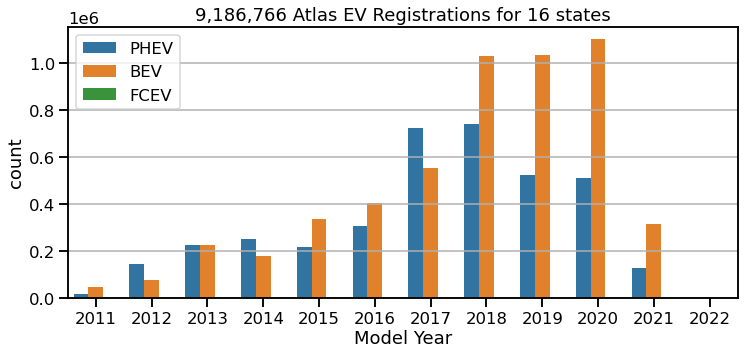

In [118]:
plt.figure(figsize=(12,5))
# sns.countplot(data=df.loc[df['Model Year']>2010,:].sample(2000), x='Model Year', hue='Technology')
sns.countplot(data=df.loc[df['Model Year']>2010,:], x='Model Year', hue='Technology')
plt.grid(axis='y')
plt.legend(loc='upper left')
plt.title(f'{total_records:,} Atlas EV Registrations for {n_states} states')
plt.show()

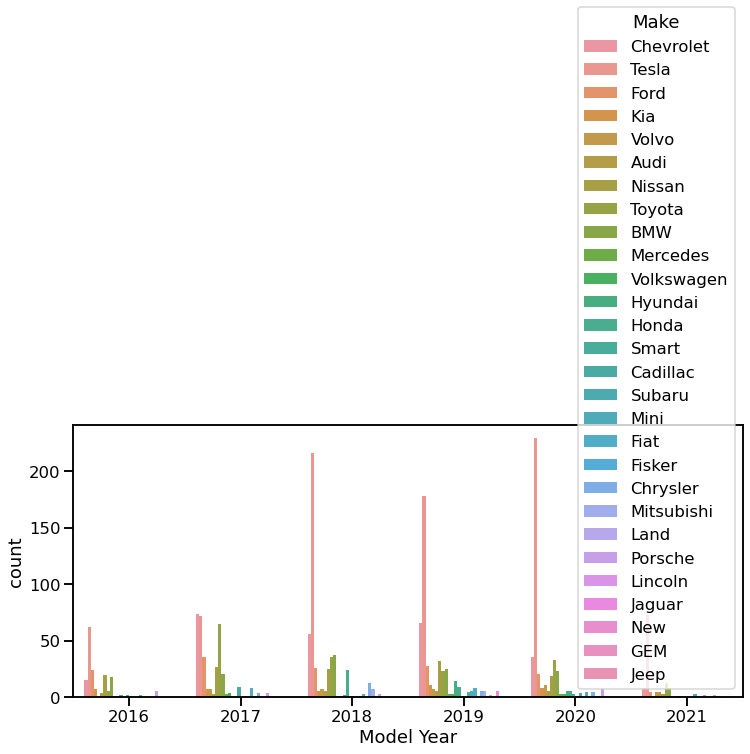

In [112]:
plt.figure(figsize=(12,5))
sns.countplot(data=df.loc[df['Model Year']>2015,:].sample(2000), x='Model Year', hue='Make')
plt.show()

# END